In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest

#### Build dataset

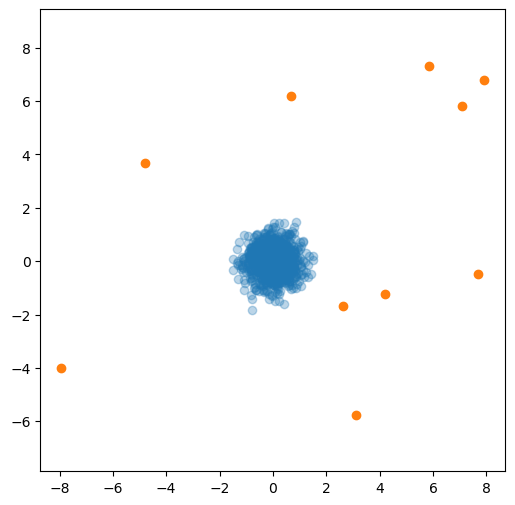

In [15]:
n_train = 1000
n_outliers = 10

X_train = pd.DataFrame(data= np.random.normal(size= (int(n_train), 2), loc= 0, scale= 0.5), 
                       columns= ['x1', 'x2'])

X_outliers = pd.DataFrame(np.random.uniform(low = -8, high= 8, size= (n_outliers, 2)), columns= ['x1', 'x2'])

X_train_w_outliers = pd.concat([X_train, X_outliers], ignore_index= True) 

plt.figure(figsize= (6, 6))
plt.scatter(x = X_train.x1, y = X_train.x2, alpha = 0.3)
plt.scatter(x = X_outliers.x1, y = X_outliers.x2)
plt.axis('equal')
plt.show()

#### Train Isolation Forest and Predict Anomaly Score and Classification

In [96]:
clf = IsolationForest(n_estimators= 100, 
                      max_samples= 0.5,
                      max_features= 1.0,
                      contamination= 'auto'
                      #contamination= (n_outliers) / (n_train + n_outliers)
                     )
                      
clf.fit(X_train_w_outliers)


iso_forest_predictions = pd.DataFrame(np.c_[clf.predict(X_train_w_outliers), 
                                            clf.decision_function(X_train_w_outliers)], 
                                      columns= ['anomaly_flag', 'anomaly_score'])

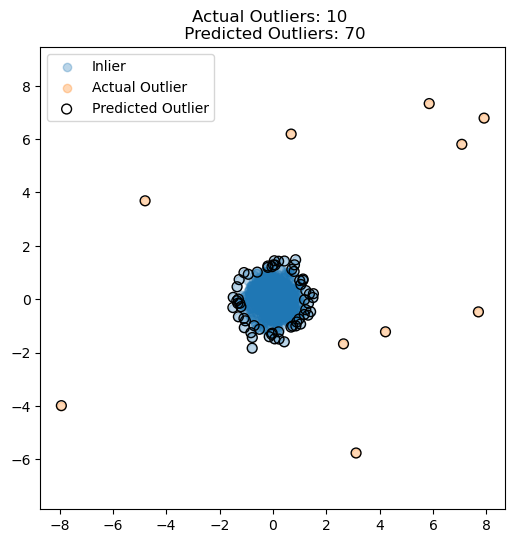

In [97]:
anom_pred = X_train_w_outliers[iso_forest_predictions.anomaly_flag == -1]


plt.figure(figsize= (6, 6))
plt.scatter(x = X_train.x1, y = X_train.x2, alpha = 0.3, label= 'Inlier')
plt.scatter(x = X_outliers.x1, y = X_outliers.x2, alpha= 0.3, label= 'Actual Outlier')
plt.scatter(x = anom_pred.x1, 
            y = anom_pred.x2, edgecolors= 'black', 
            facecolors= 'none', s= 50, label= 'Predicted Outlier')
plt.legend()
plt.title('Actual Outliers: %d \n Predicted Outliers: %d' % (X_outliers.shape[0], 
                                                             anom_pred.shape[0]))
plt.axis('equal')
plt.show()

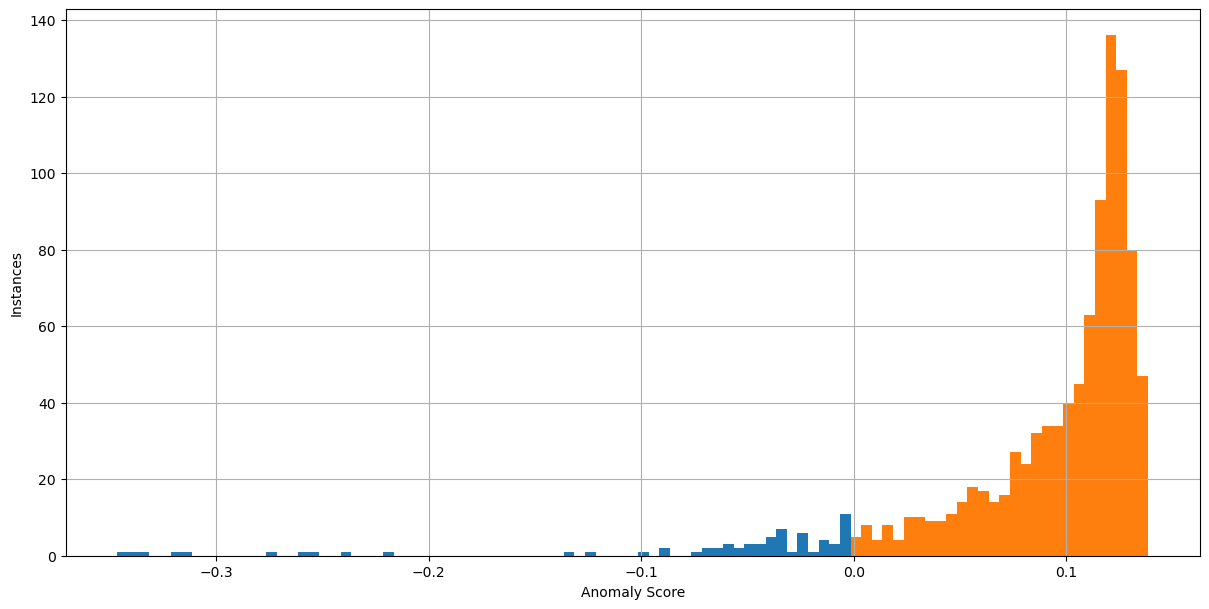

In [98]:
fig, ax = plt.subplots()
iso_forest_predictions.groupby(['anomaly_flag'])['anomaly_score'].hist(
    bins= np.arange(np.min(clf.decision_function(X_train_w_outliers)), 
                    np.max(clf.decision_function(X_train_w_outliers)), 0.005),  
    figsize= (12, 6), ax= ax)
fig.tight_layout()
plt.xlabel('Anomaly Score')
plt.ylabel('Instances')
plt.show()

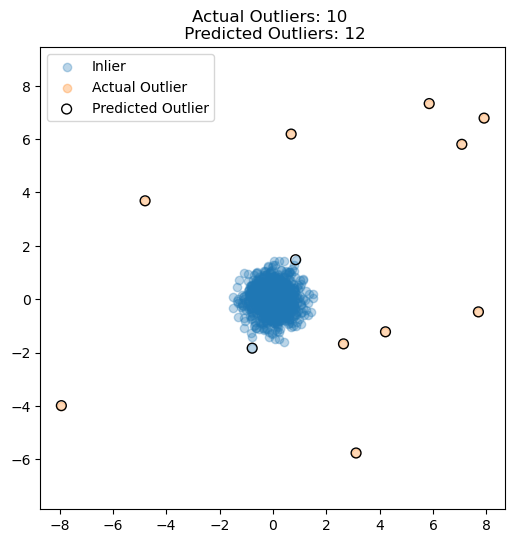

In [100]:
anom_pred_updated = anom_pred = X_train_w_outliers[iso_forest_predictions.anomaly_score < -0.1]

plt.figure(figsize= (6, 6))
plt.scatter(x = X_train.x1, y = X_train.x2, alpha = 0.3, label= 'Inlier')
plt.scatter(x = X_outliers.x1, y = X_outliers.x2, alpha= 0.3, label= 'Actual Outlier')
plt.scatter(x = anom_pred_updated.x1, y = anom_pred_updated.x2, 
            edgecolors= 'black', facecolors= 'none', s= 50, label= 'Predicted Outlier')
plt.legend()
plt.title('Actual Outliers: %d \n Predicted Outliers: %d' % (X_outliers.shape[0], 
                                                             anom_pred_updated.shape[0]))
plt.axis('equal')
plt.show()

In [101]:
print(f'Number of trees: {clf.n_estimators}')
print(f'Rows sampled per tree: {clf.max_samples}')
print(f'Number of rows sampled: {clf.max_samples_} from {X_train_w_outliers.shape[0]}')

Number of trees: 100
Rows sampled per tree: 0.5
Number of rows sampled: 505 from 1010


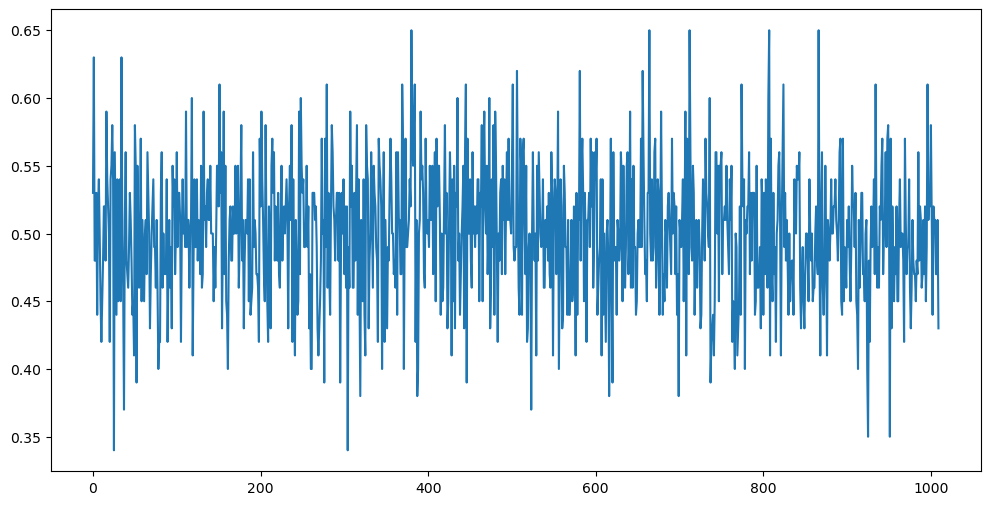

In [102]:
sample_index, index_count = np.unique(np.concatenate(clf.estimators_samples_, axis= 0), return_counts= True)

plt.figure(figsize= (12, 6))
plt.plot(sample_index, index_count / clf.n_estimators)
plt.show()

### Calculate the tree depths for each data point in each tree

In [103]:
n_samples = X_train_w_outliers.shape[0]
n_samples_leaf = np.zeros((n_samples, clf.n_estimators), order="f")
depths = np.zeros((n_samples, clf.n_estimators), order="f")

for i, (tree, features) in enumerate(zip(clf.estimators_, clf.estimators_features_)):
    X_subset = X_train_w_outliers[X_train_w_outliers.columns[features]]
    leaves_index = tree.apply(X_subset.values)
    node_indicator = tree.decision_path(X_subset.values)
    n_samples_leaf[:, i] = tree.tree_.n_node_samples[leaves_index]
    depths[:, i] = np.ravel(node_indicator.sum(axis=1))
    depths[:, i] -= 1

array([[9., 9., 9., ..., 9., 9., 9.],
       [9., 7., 9., ..., 9., 9., 9.],
       [9., 9., 9., ..., 9., 9., 9.],
       ...,
       [1., 2., 2., ..., 1., 4., 3.],
       [4., 6., 3., ..., 2., 3., 1.],
       [5., 6., 3., ..., 2., 3., 1.]])

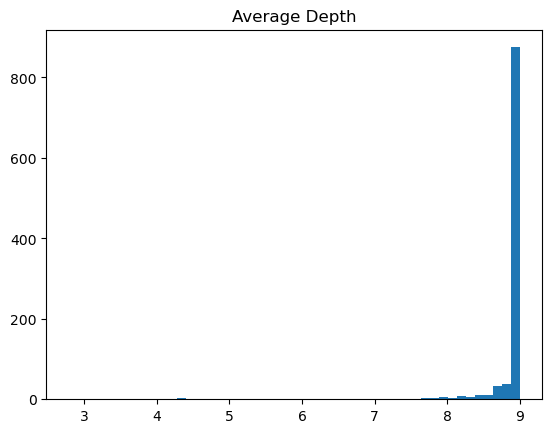

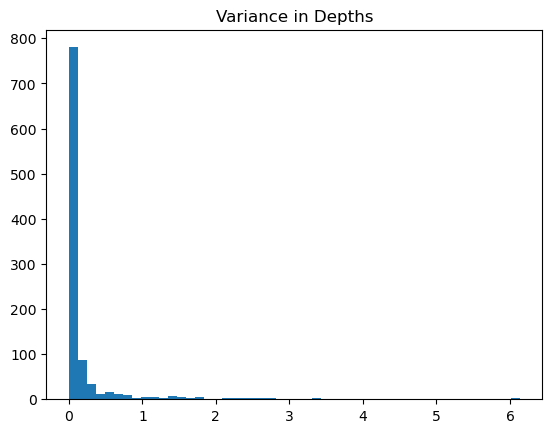

In [104]:
display(depths)

plt.figure(num= 0)
plt.hist(depths.mean(axis = 1), bins= 50);
plt.title('Average Depth');

plt.figure(num= 1)
plt.hist(depths.var(axis = 1), bins= 50);
plt.title('Variance in Depths');


#### Max depth $\psi$ is the ceiling of $log_2(\text{tree subsample size})$
#### n_samples is the product of max_samples and the full data set size

In [105]:
## The value is an attribute in the classifier object
print(clf.max_samples_)
## Therefore, the max depth is
print("Max depth: %d" % np.ceil(np.log2(clf.max_samples_)))

505
Max depth: 9


In [106]:
X_outliers.values.astype('float32')

array([[ 4.220214 , -1.2238002],
       [ 3.1173859, -5.7678466],
       [-4.7929797,  3.6874926],
       [ 7.9169674,  6.7880316],
       [ 7.082049 ,  5.8057723],
       [ 2.645798 , -1.6765435],
       [ 7.7045016, -0.4769636],
       [-7.932502 , -3.992694 ],
       [ 0.6831269,  6.189787 ],
       [ 5.859476 ,  7.333582 ]], dtype=float32)

In [107]:
clf.estimators_[0].tree_.decision_path(X_outliers.values.astype('float32')).sum(axis = 1)

matrix([[6],
        [2],
        [5],
        [7],
        [6],
        [5],
        [7],
        [2],
        [5],
        [6]])

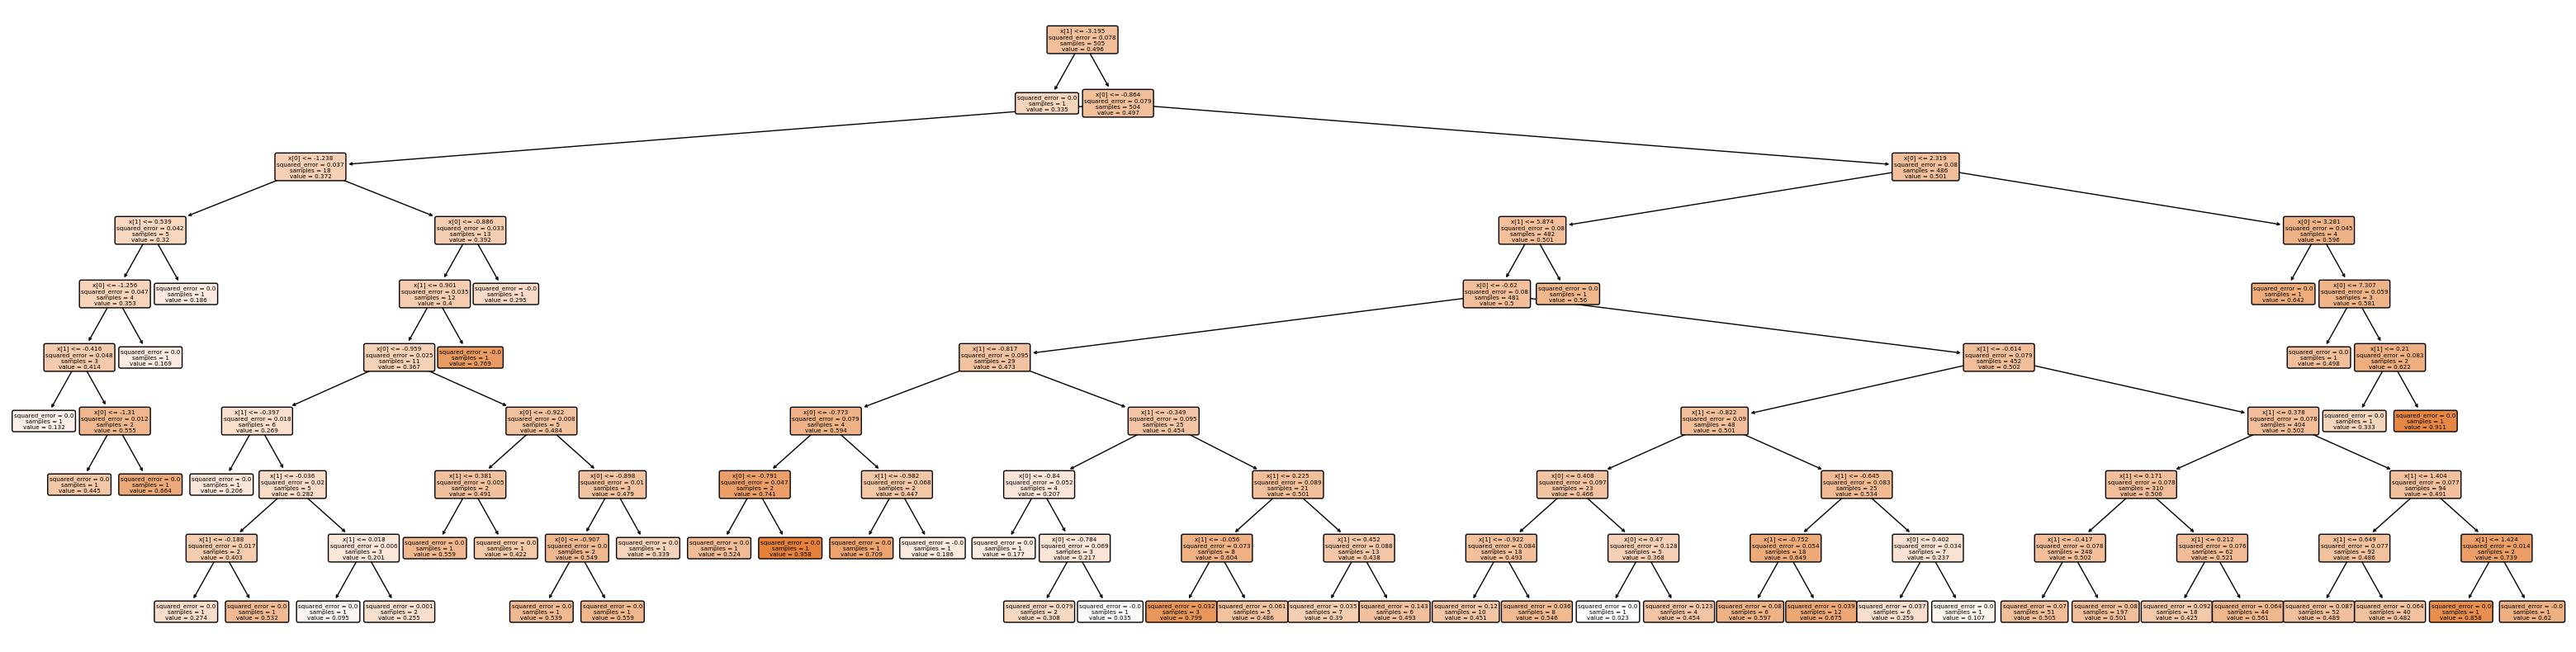

In [108]:
from sklearn import tree

plt.figure(figsize= (40, 10))
tree.plot_tree(decision_tree= clf.estimators_[0], 
               rounded= True, 
               filled= True)
plt.show()

#### Show a tree's decision logic

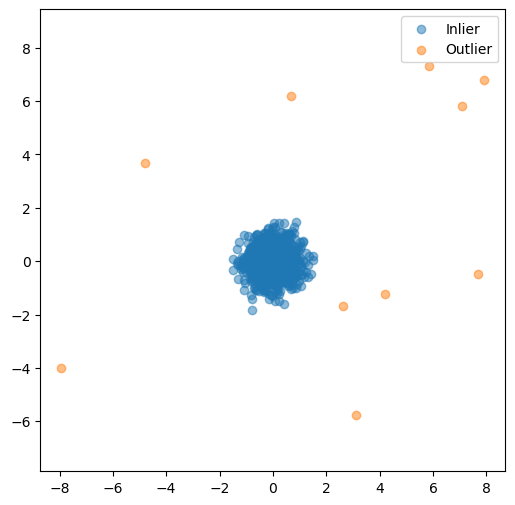

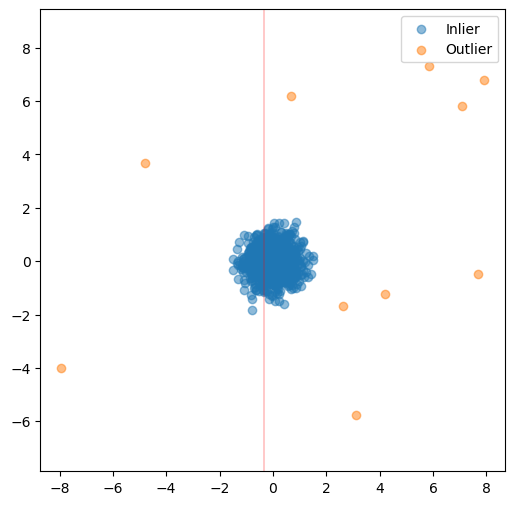

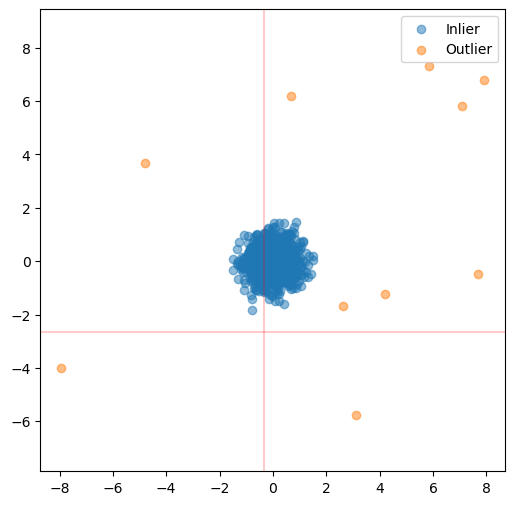

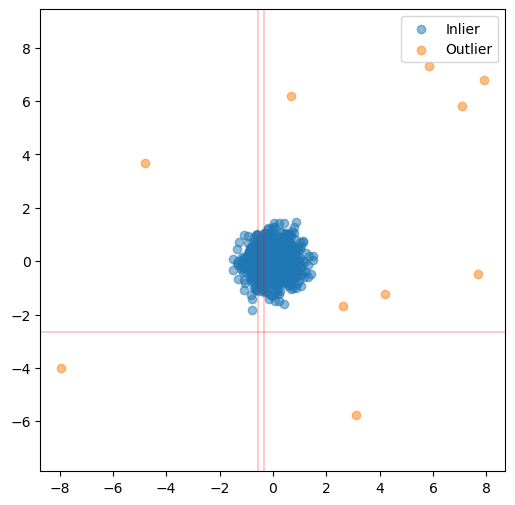

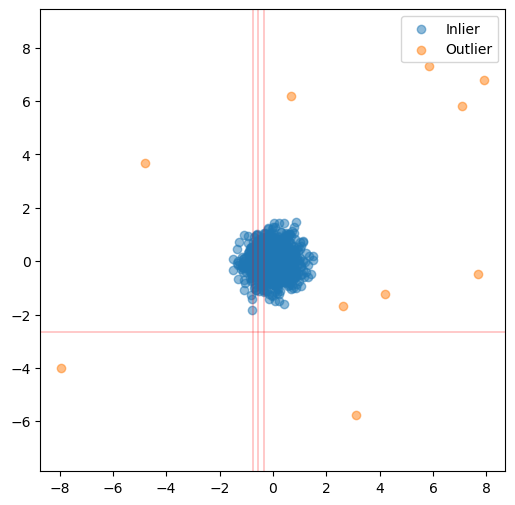

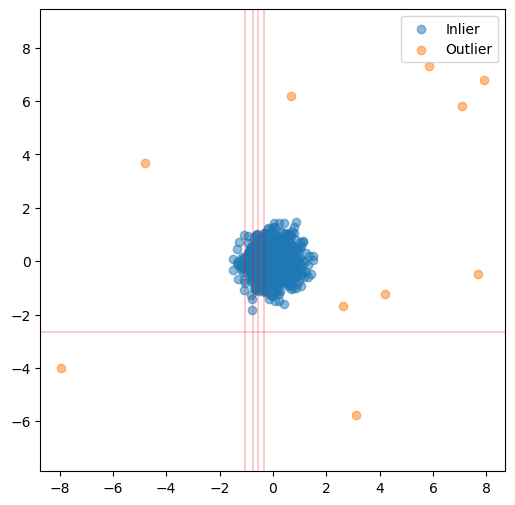

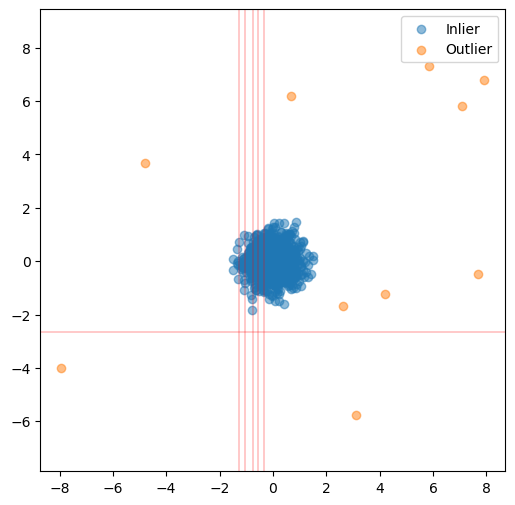

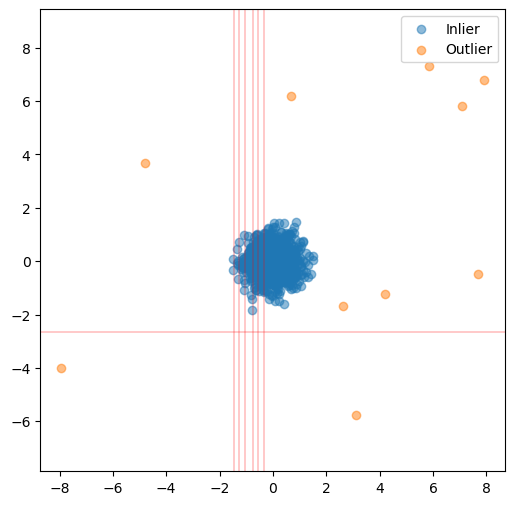

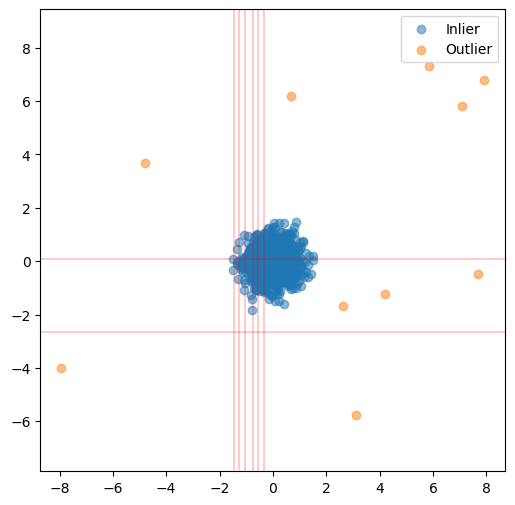

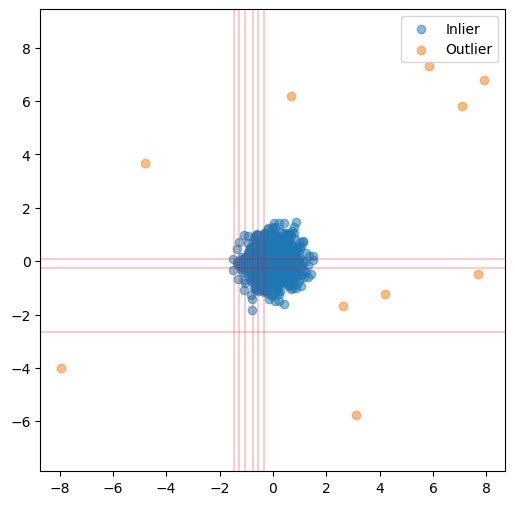

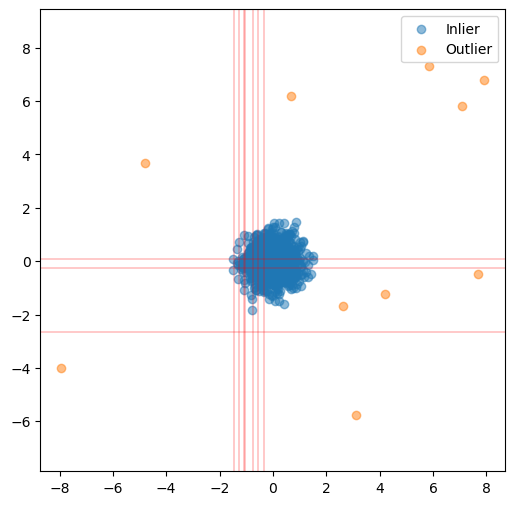

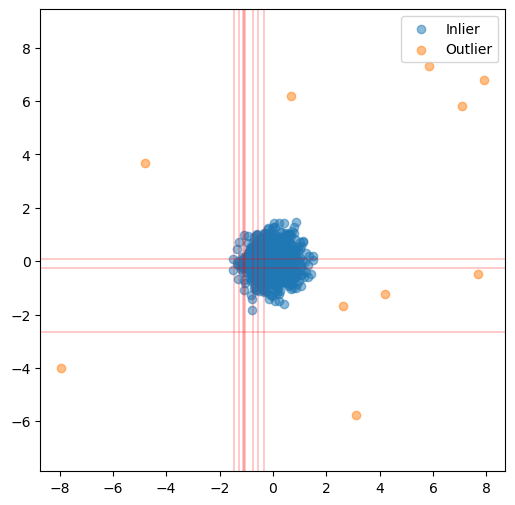

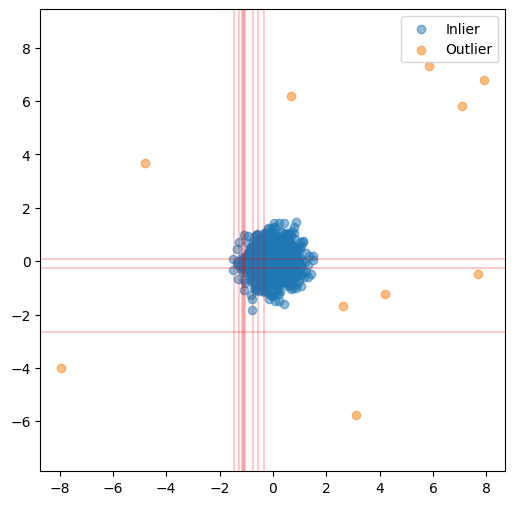

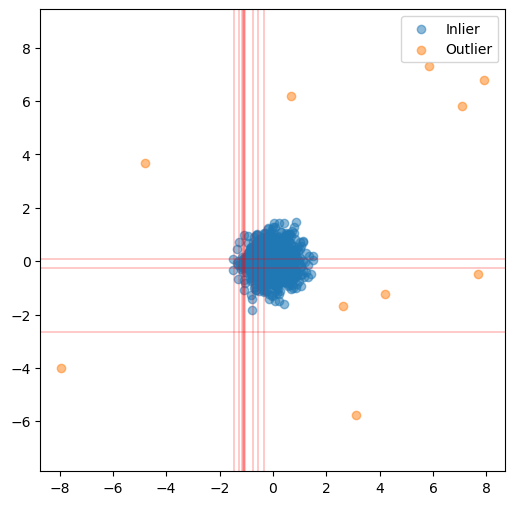

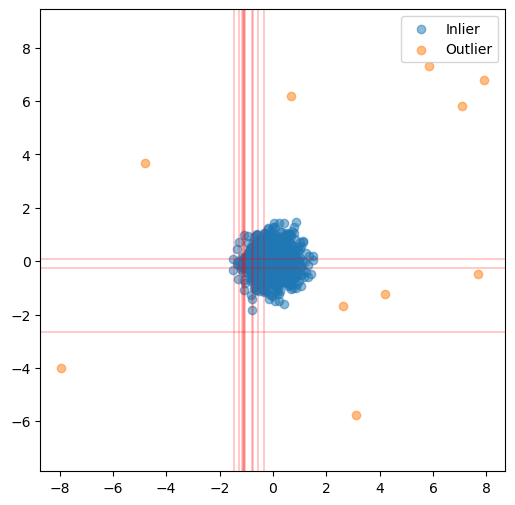

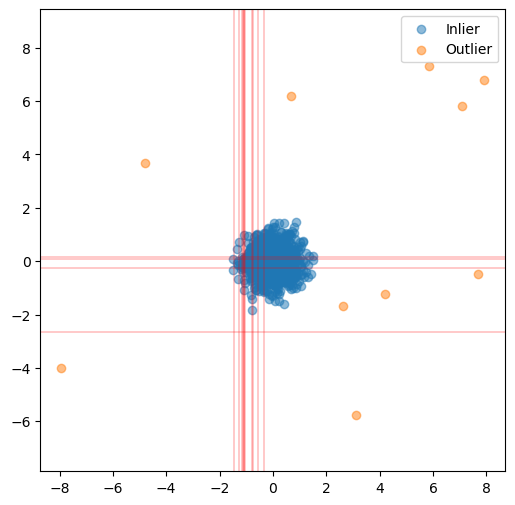

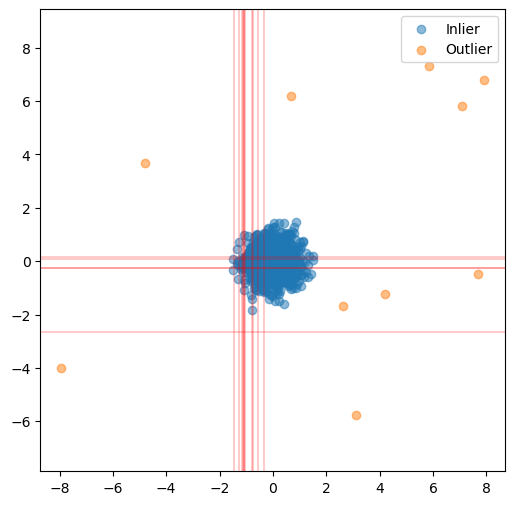

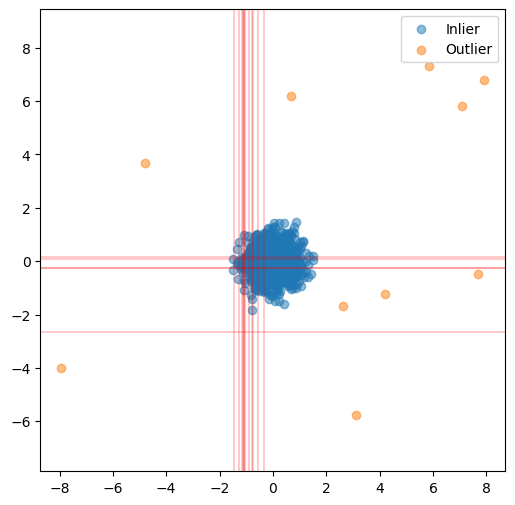

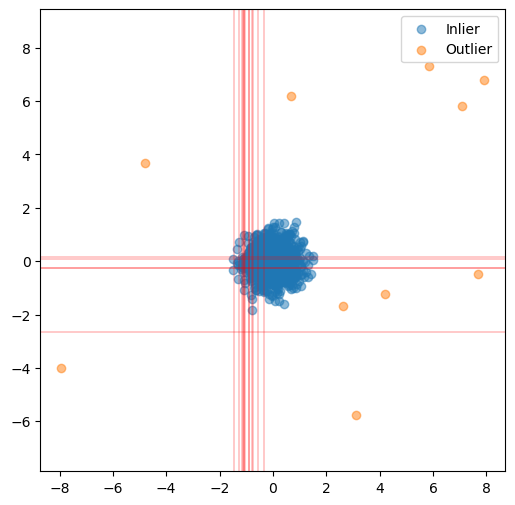

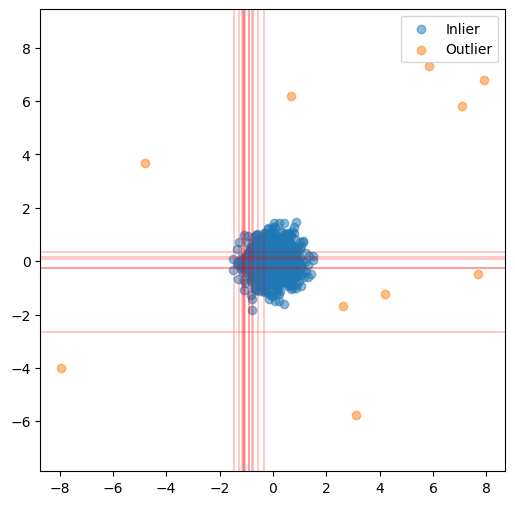

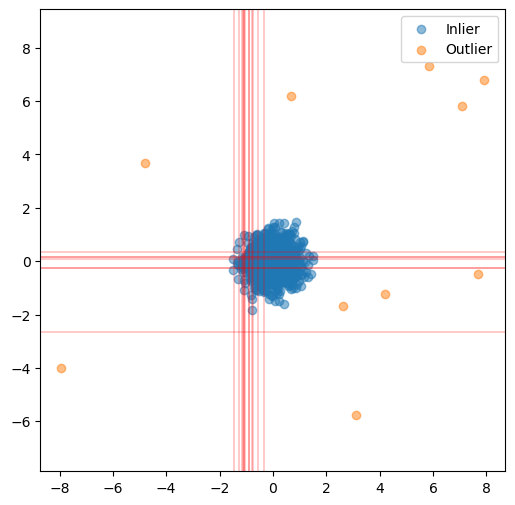

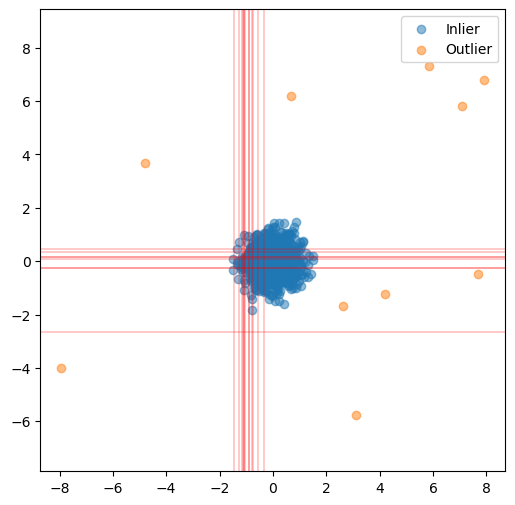

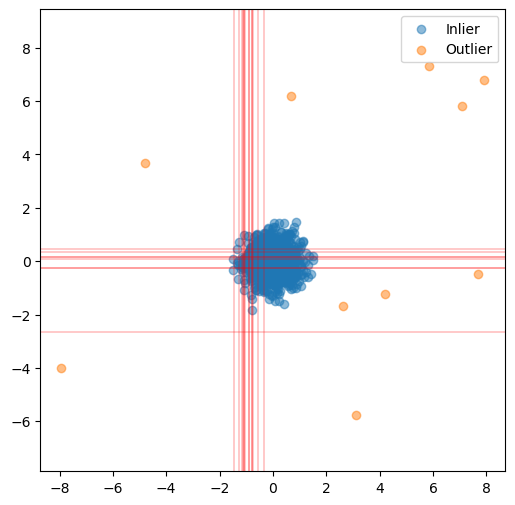

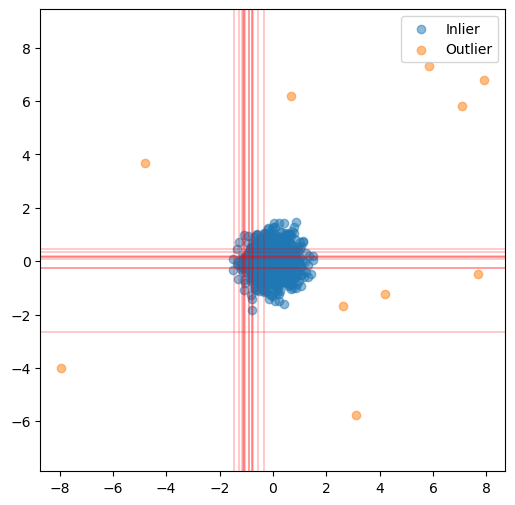

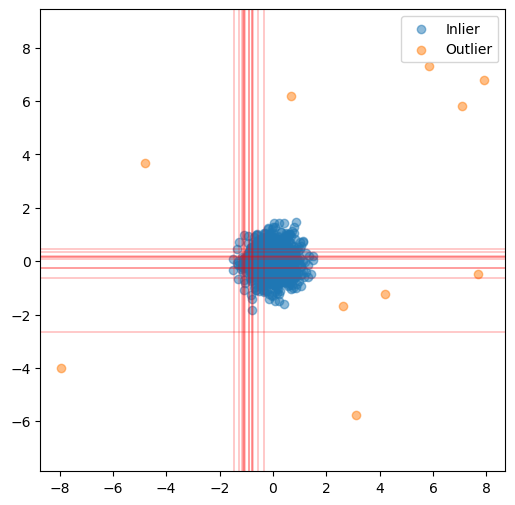

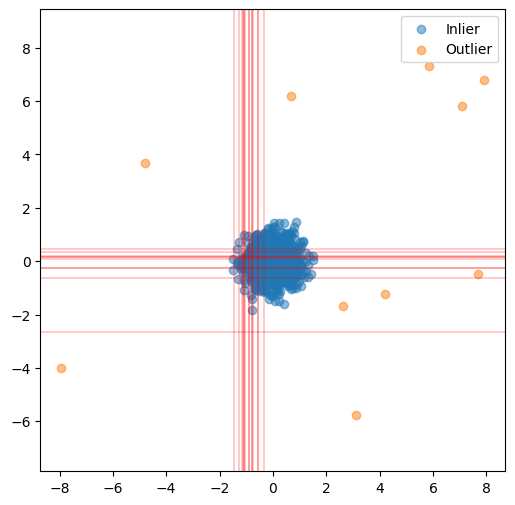

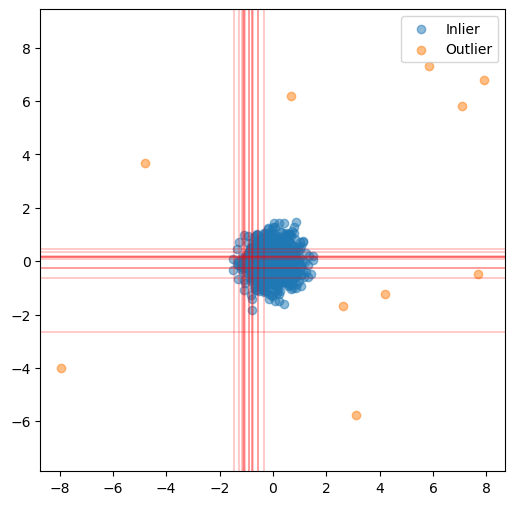

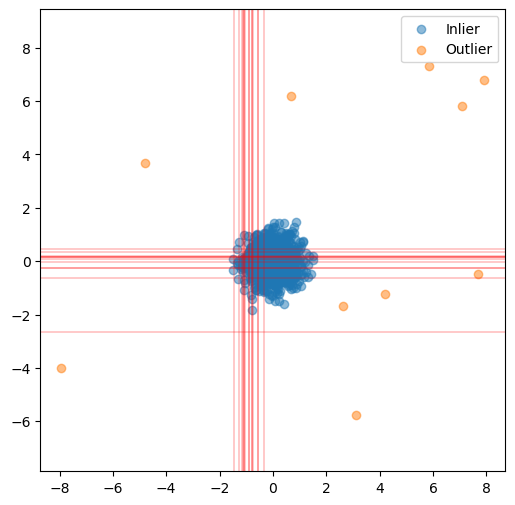

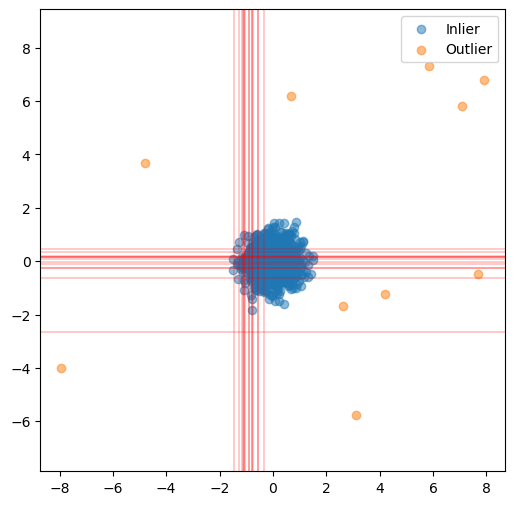

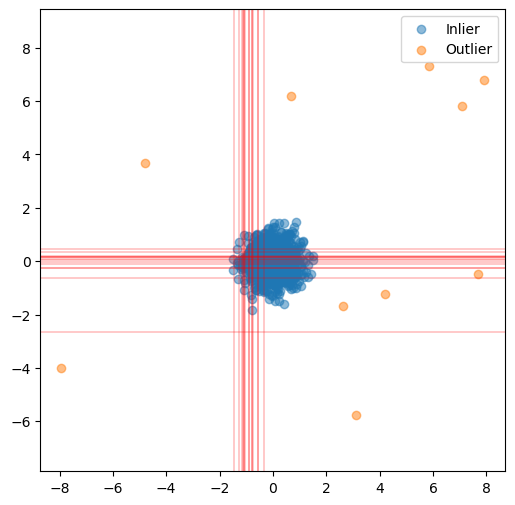

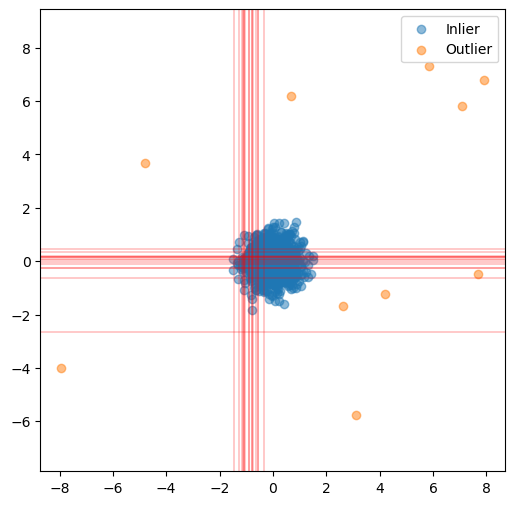

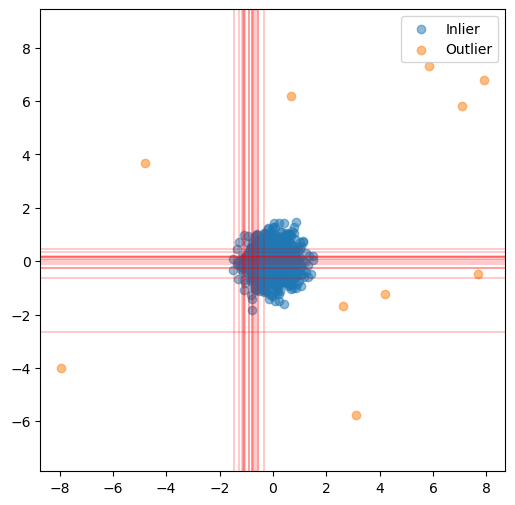

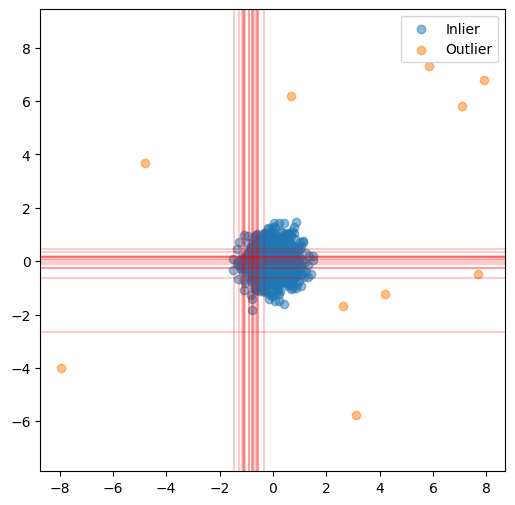

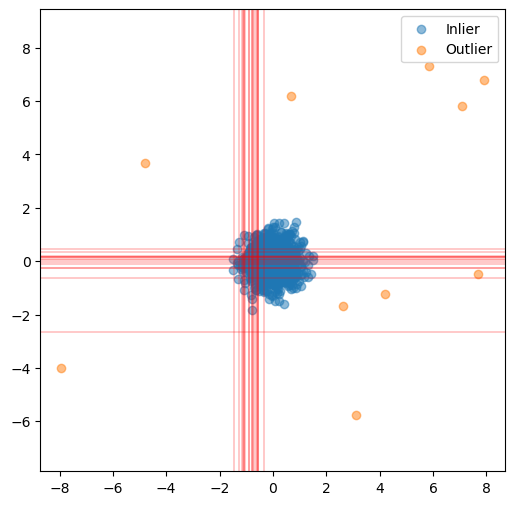

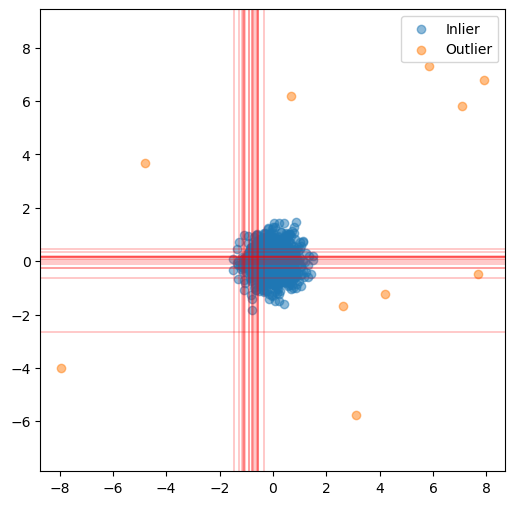

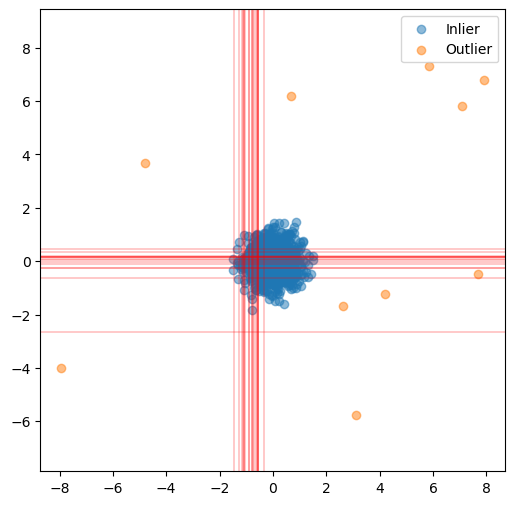

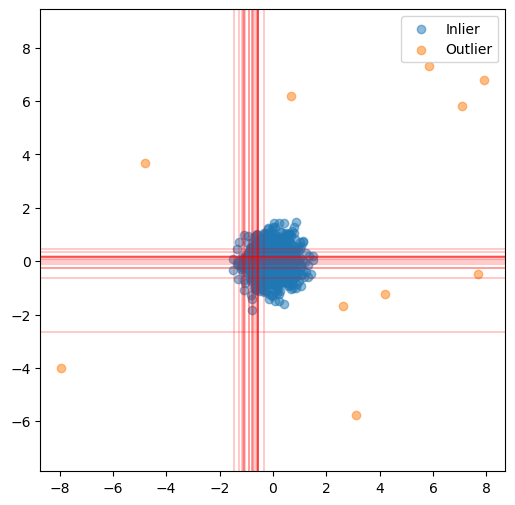

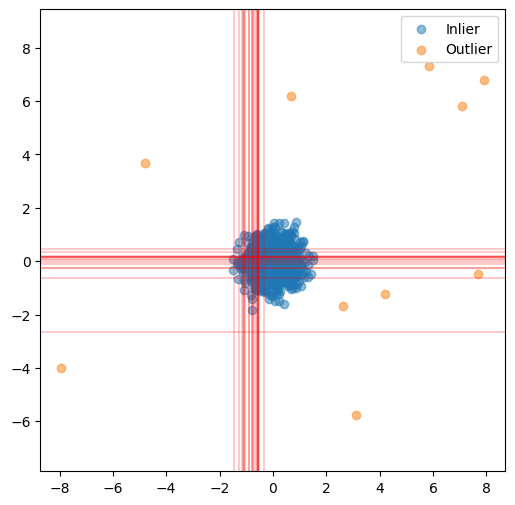

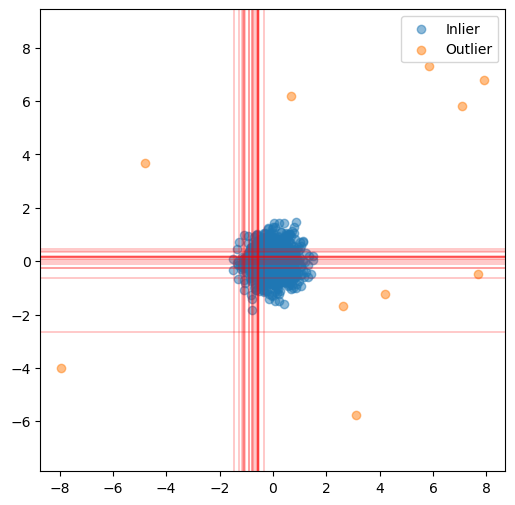

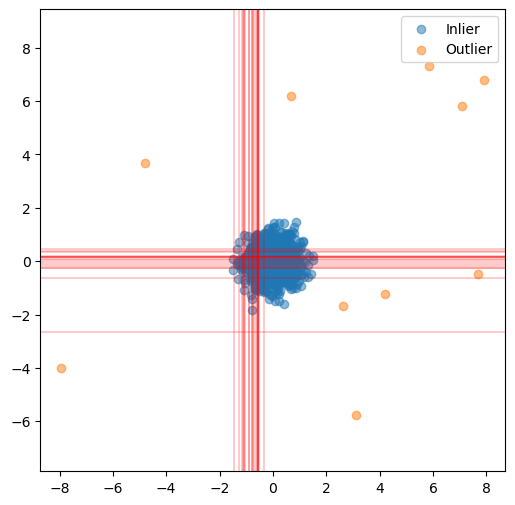

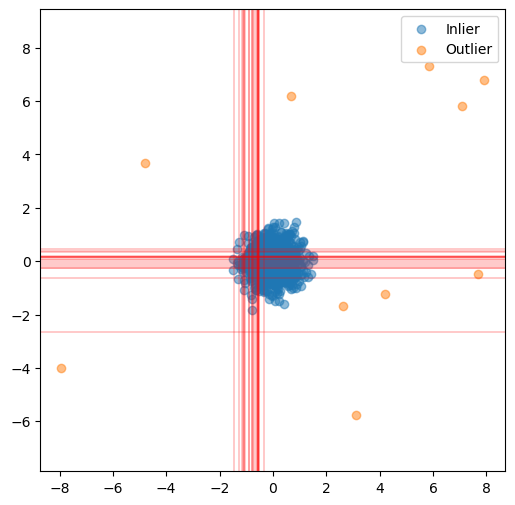

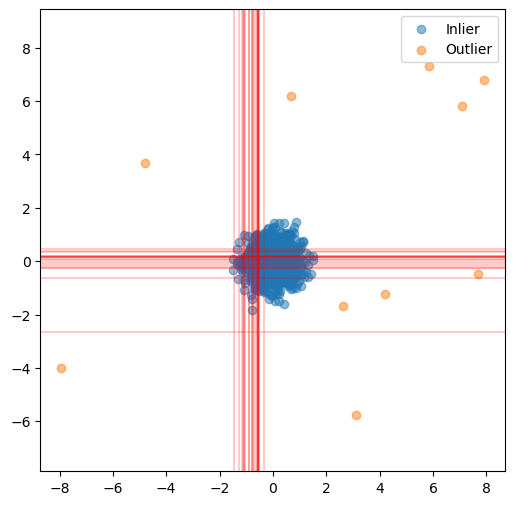

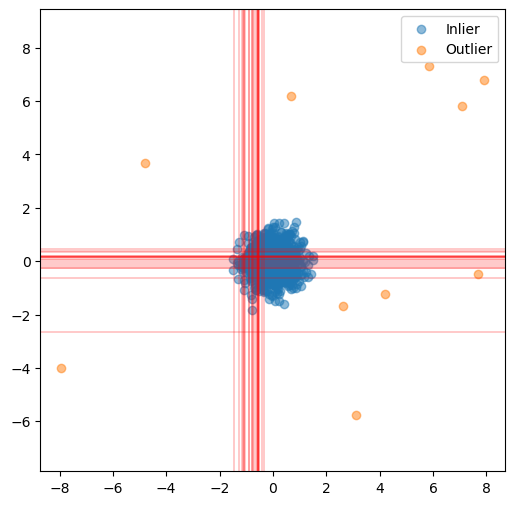

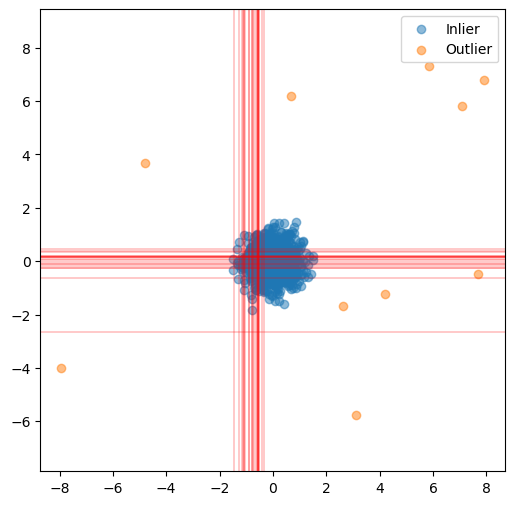

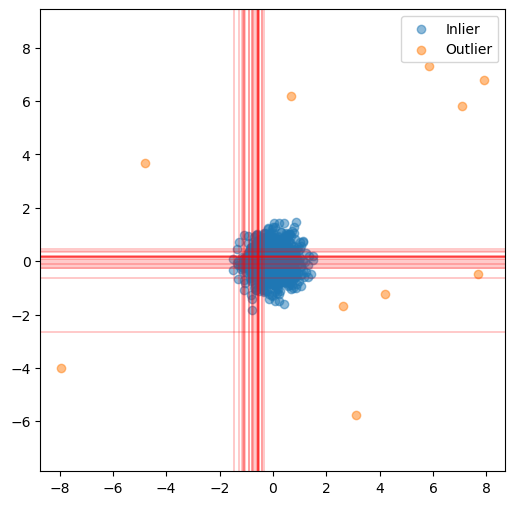

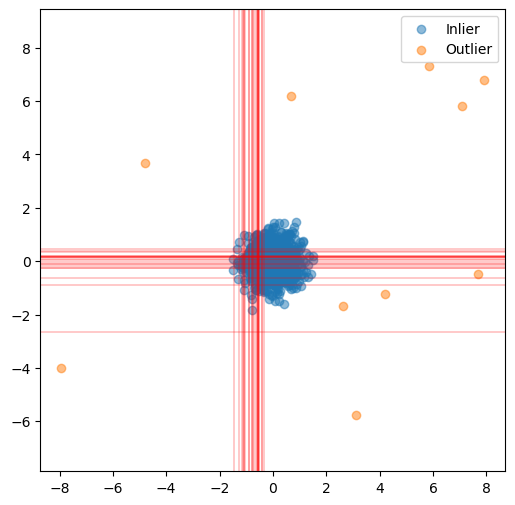

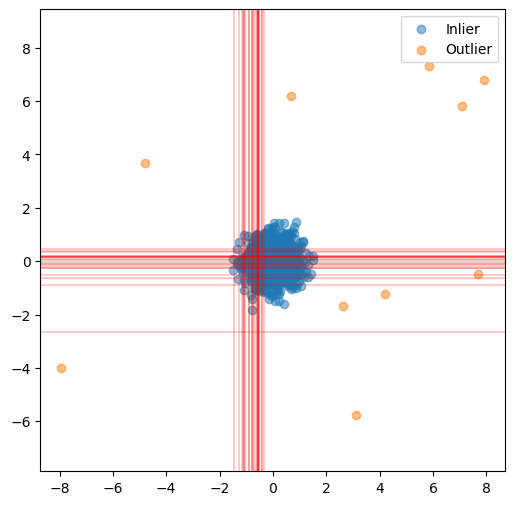

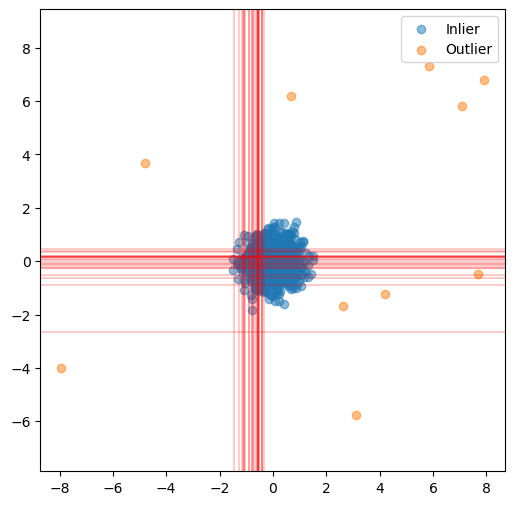

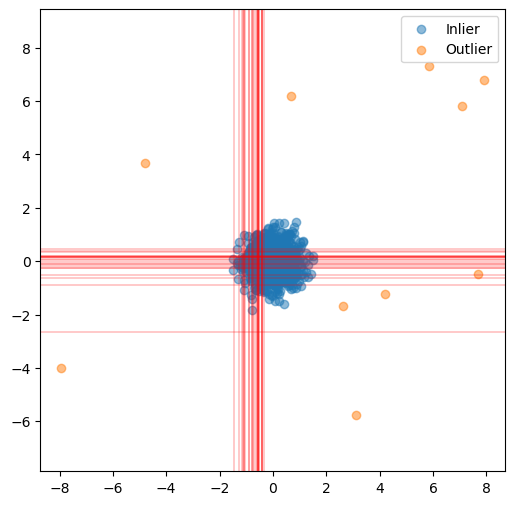

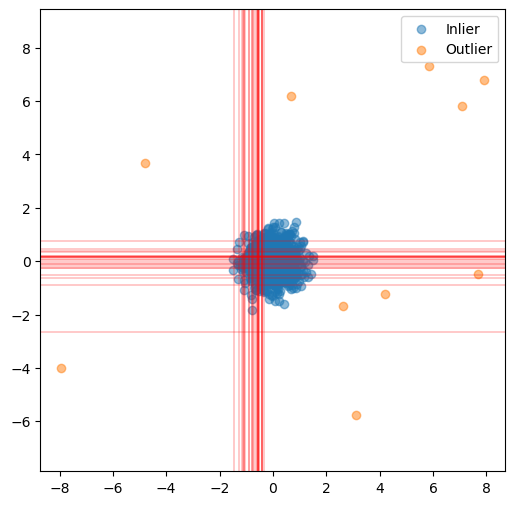

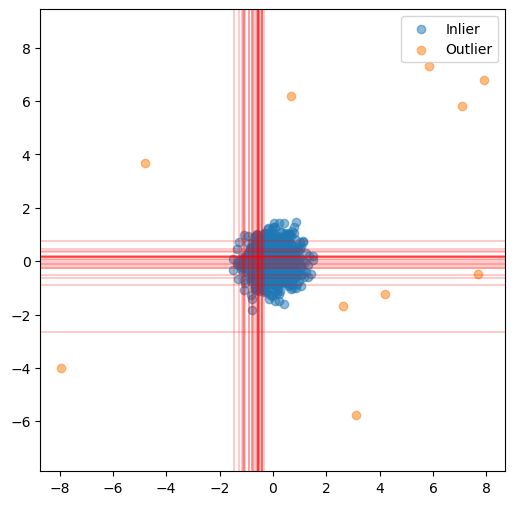

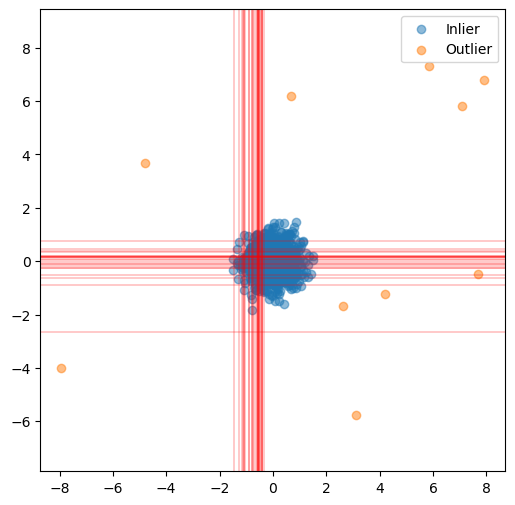

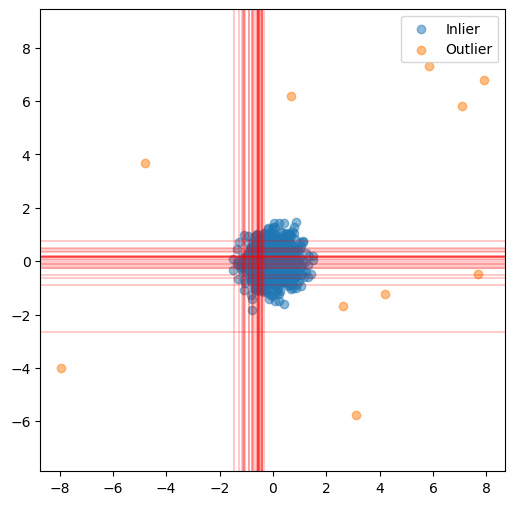

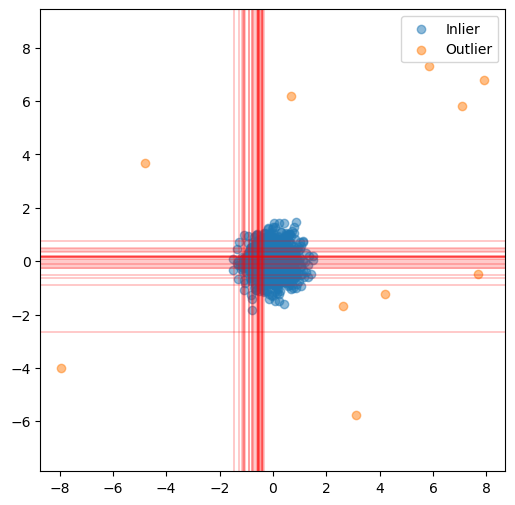

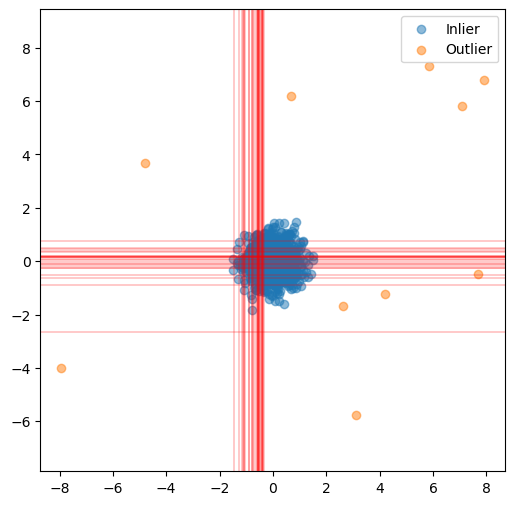

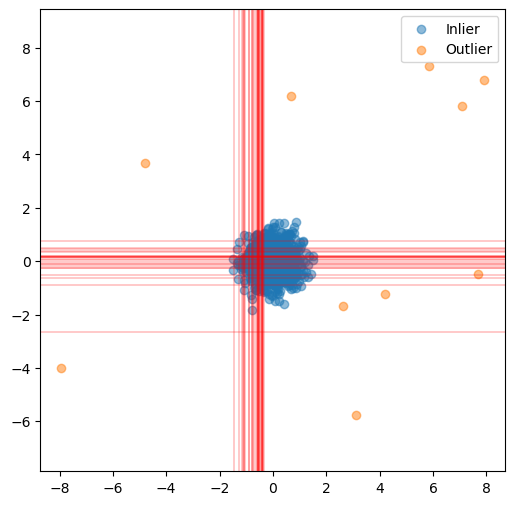

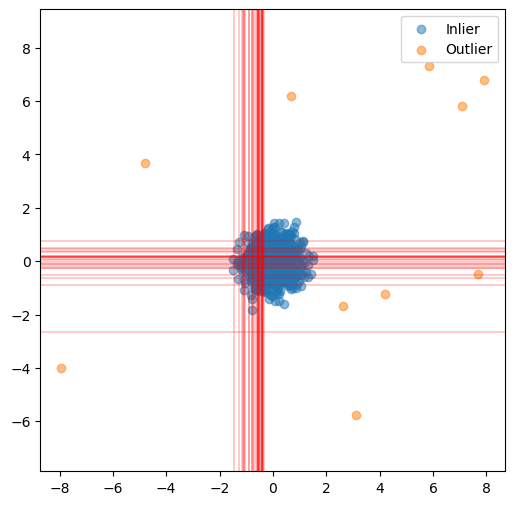

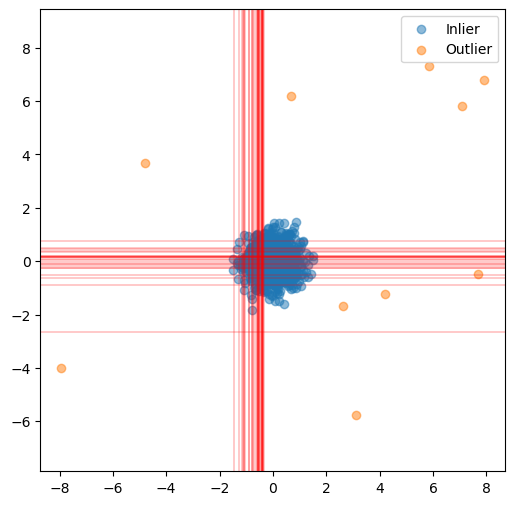

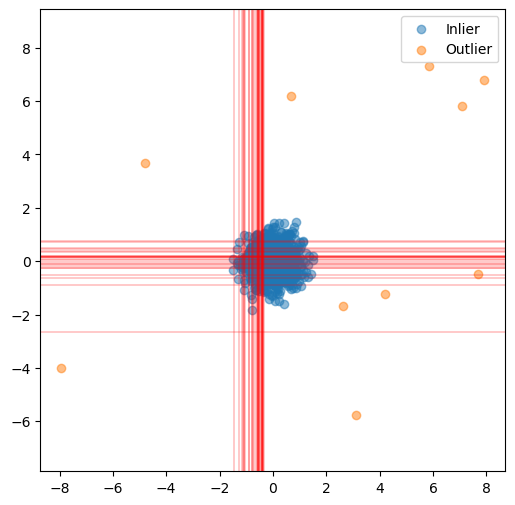

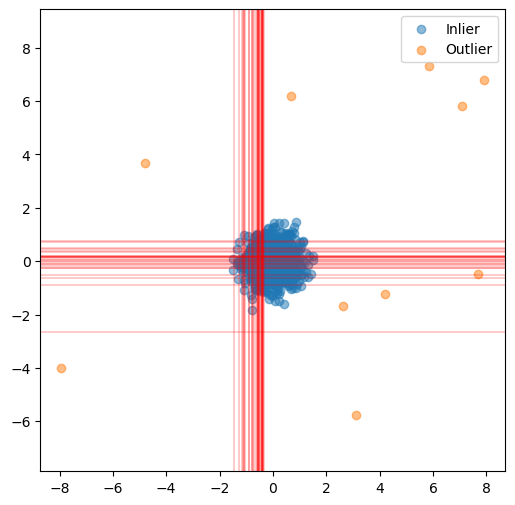

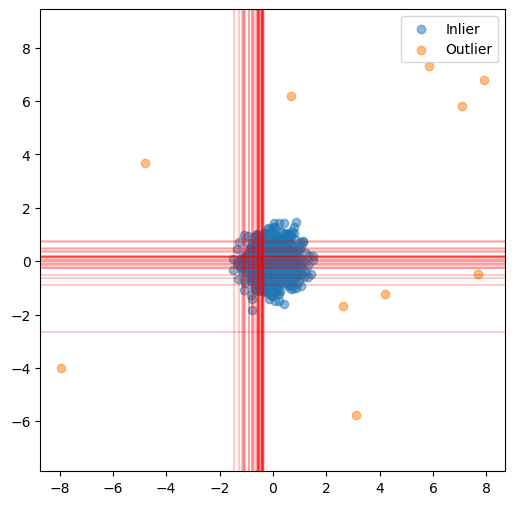

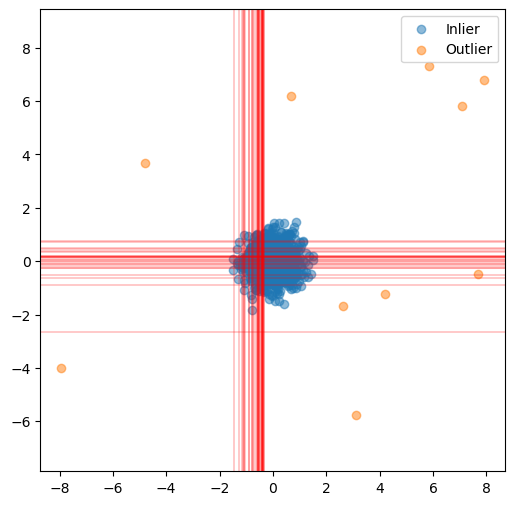

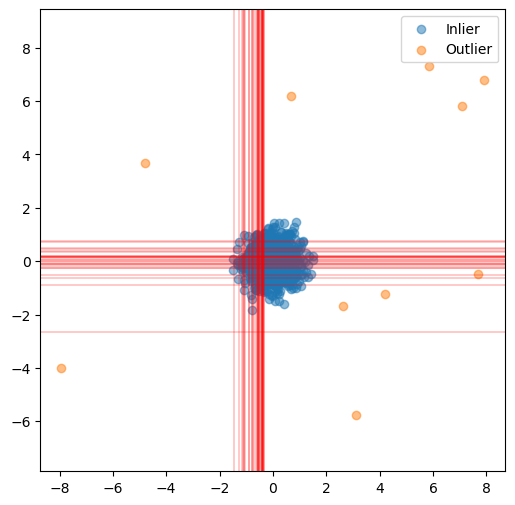

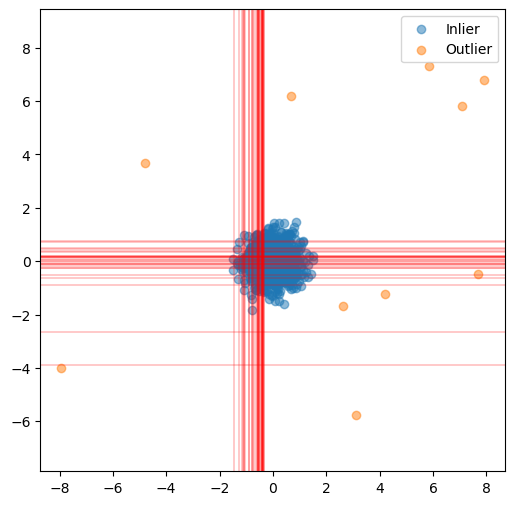

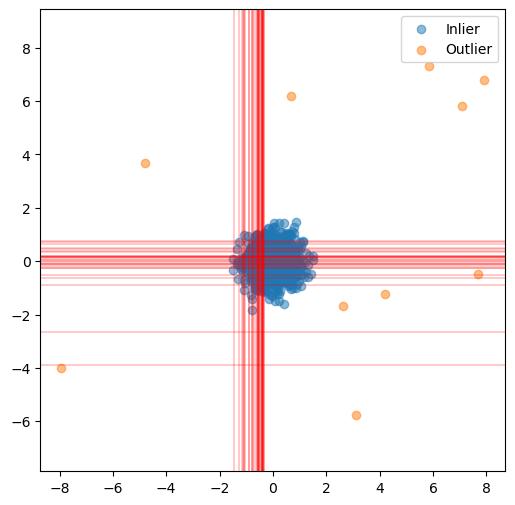

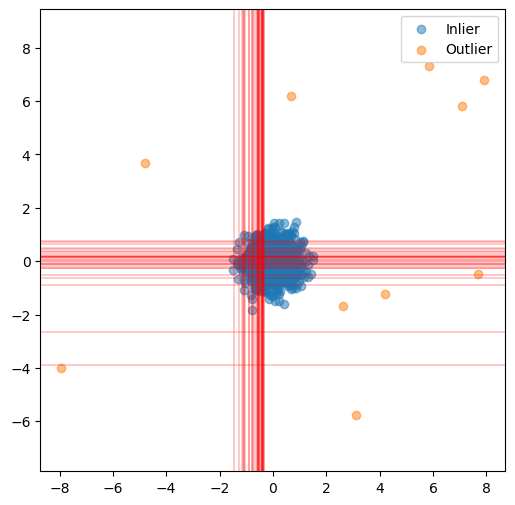

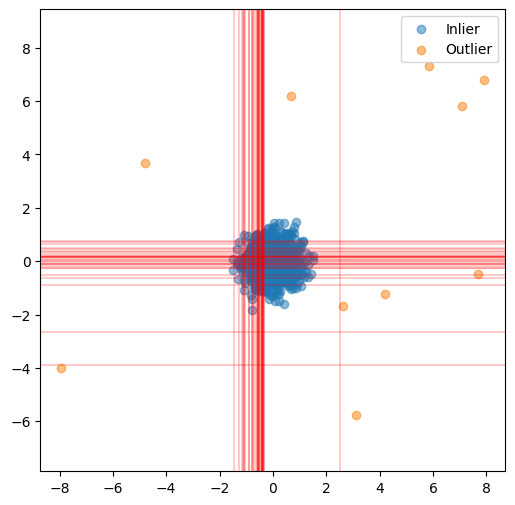

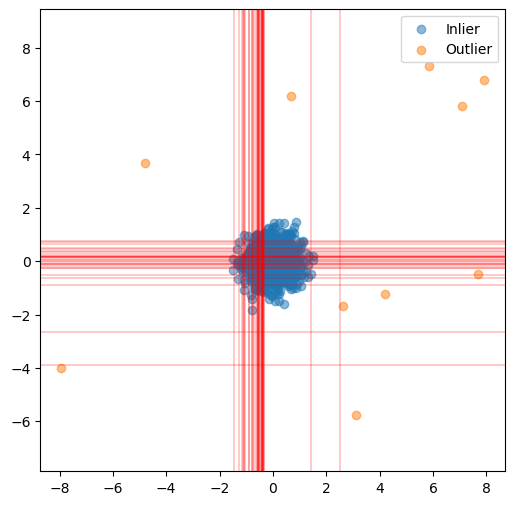

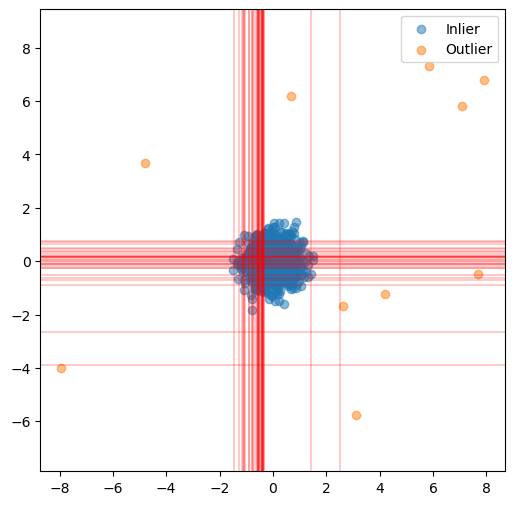

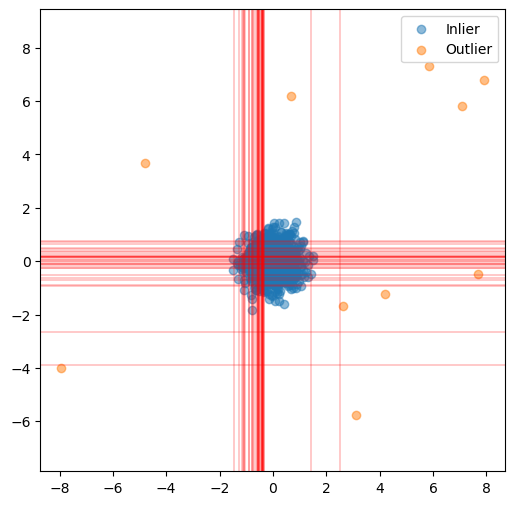

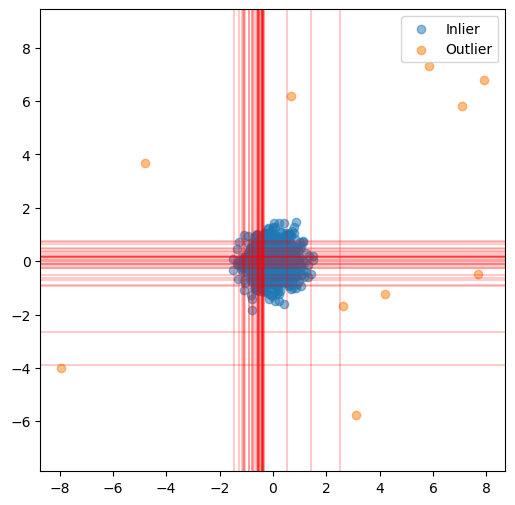

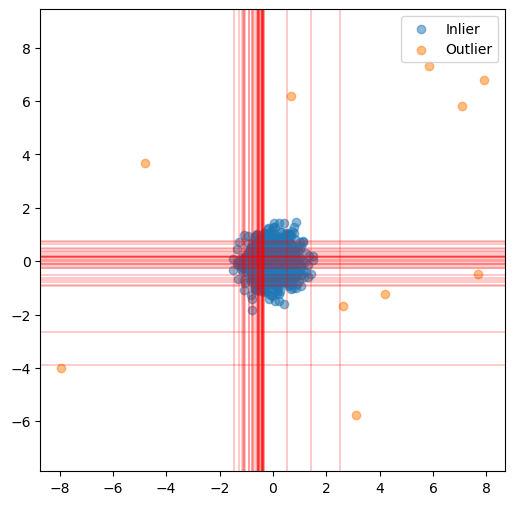

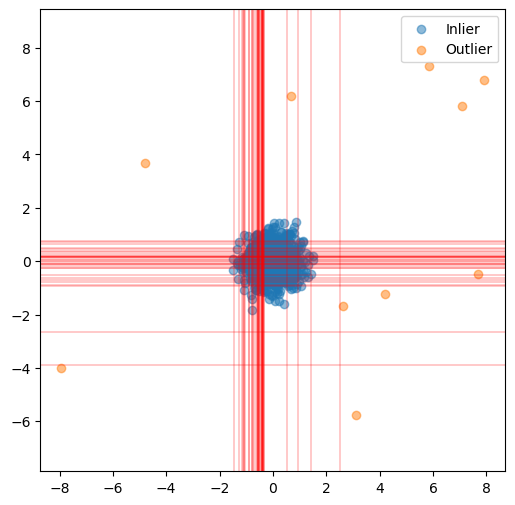

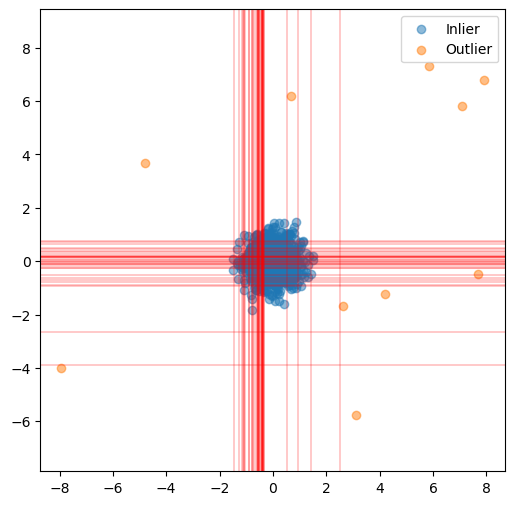

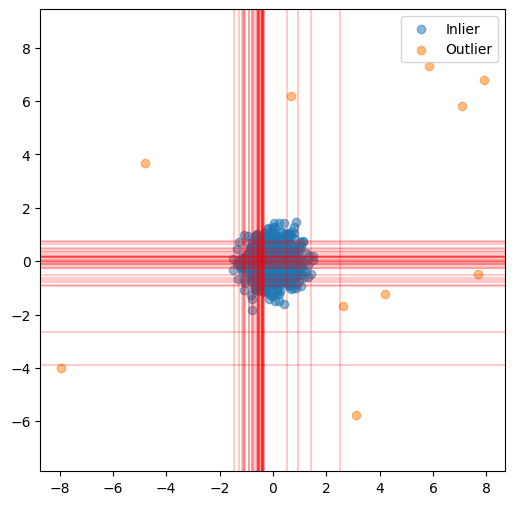

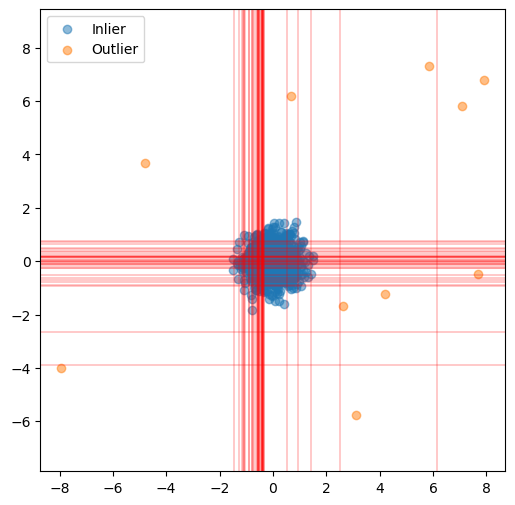

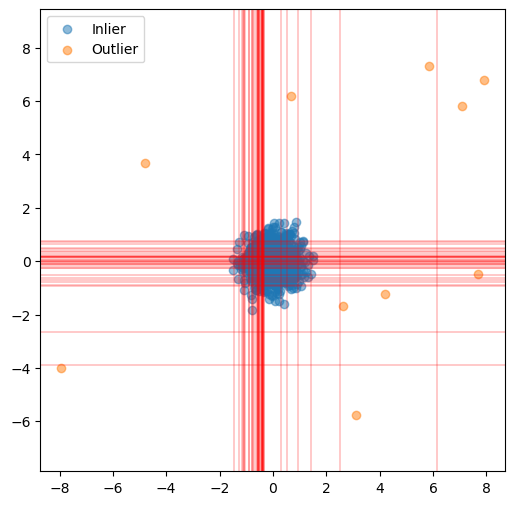

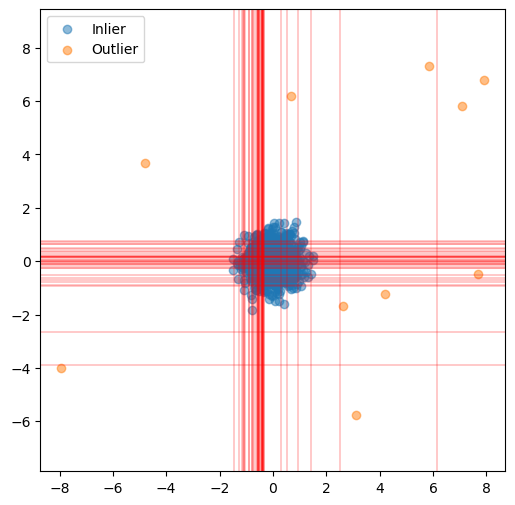

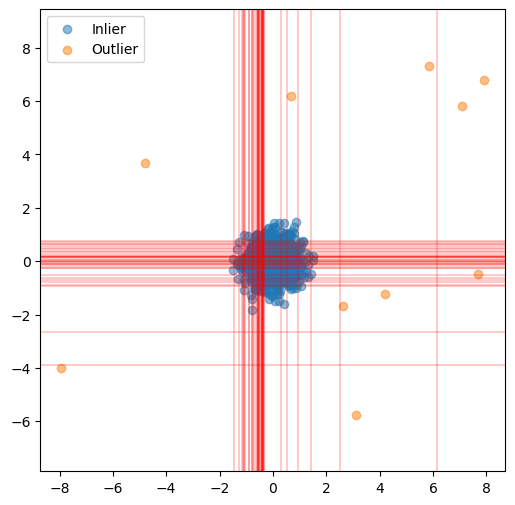

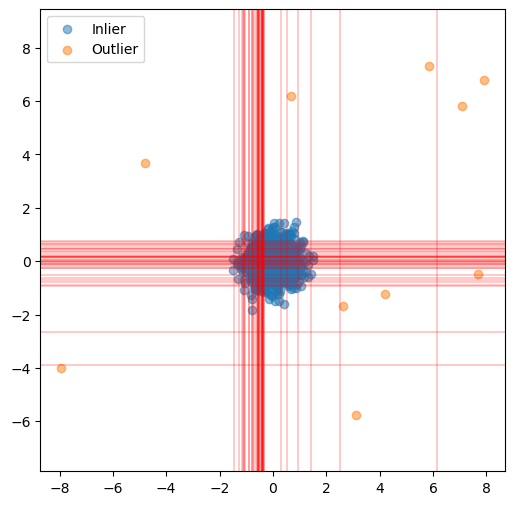

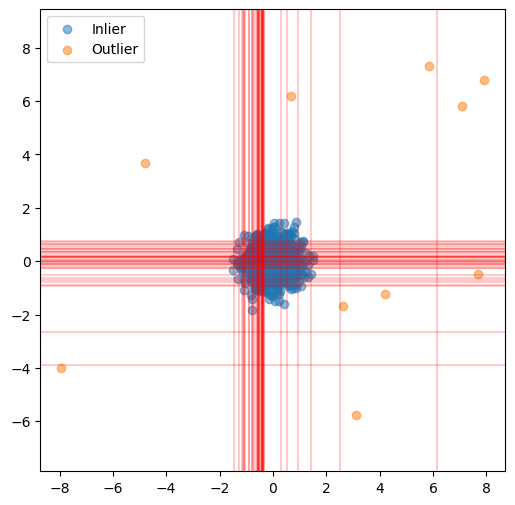

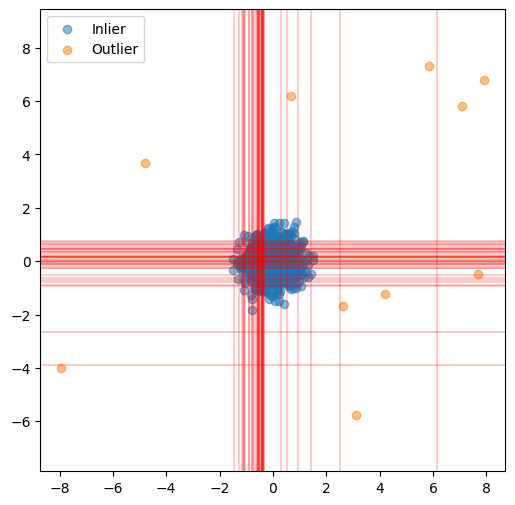

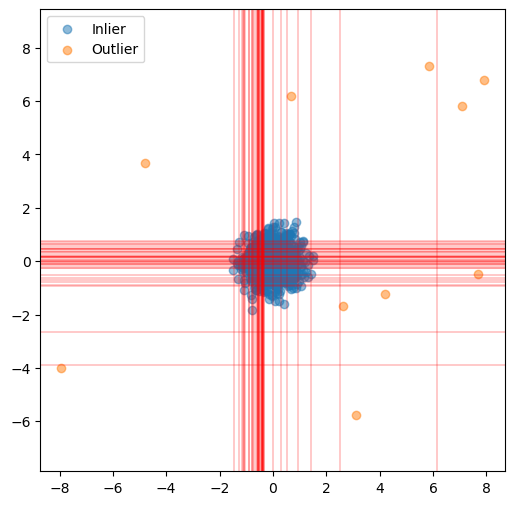

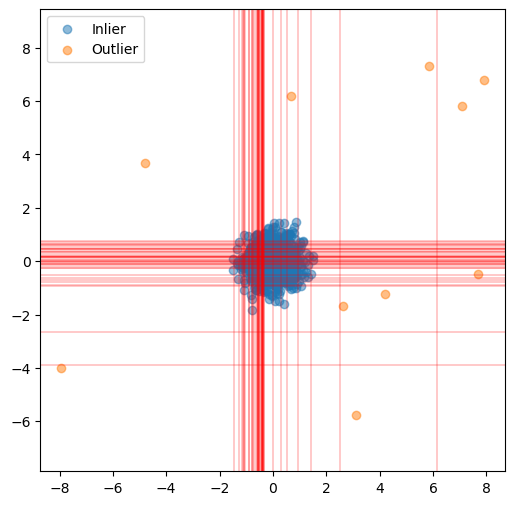

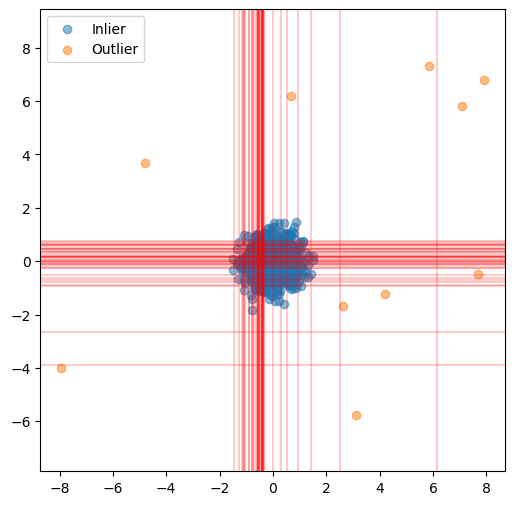

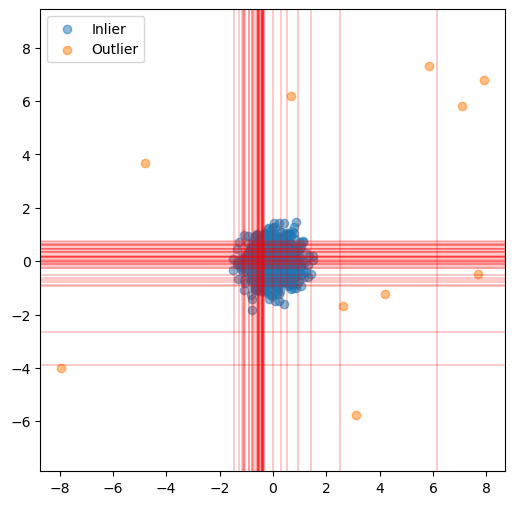

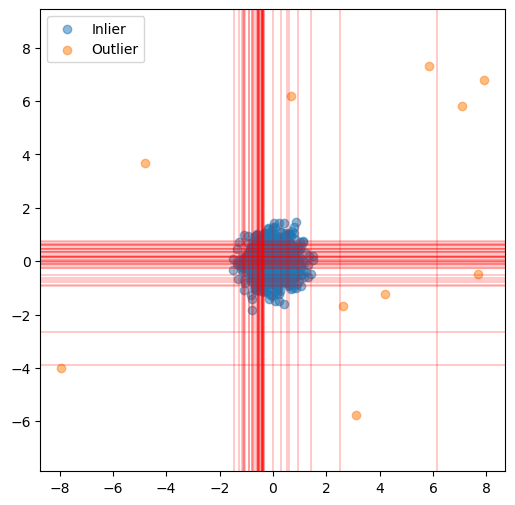

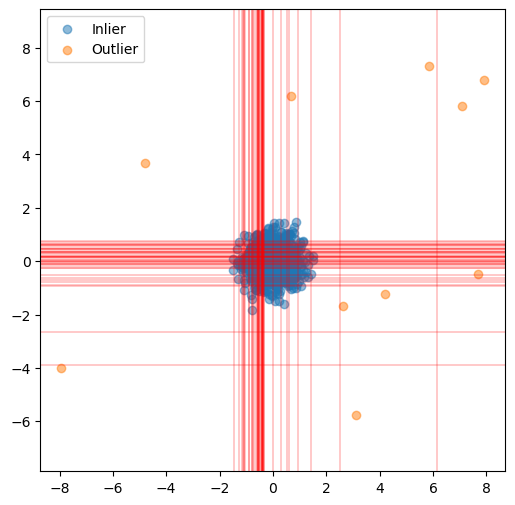

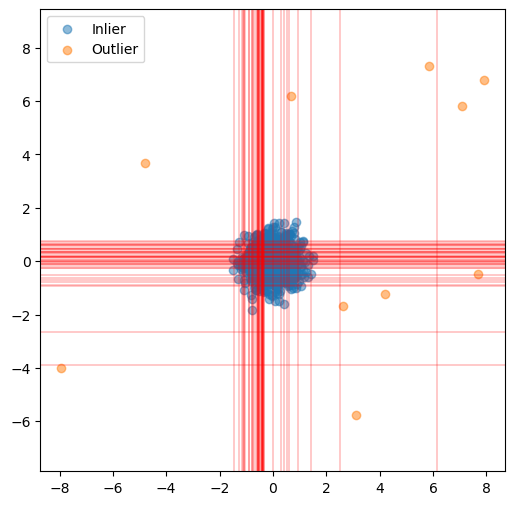

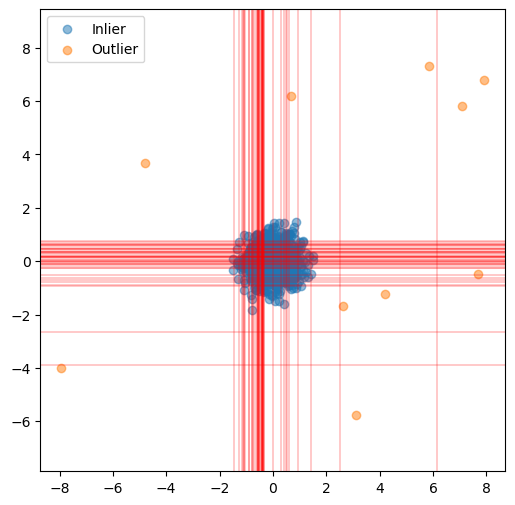

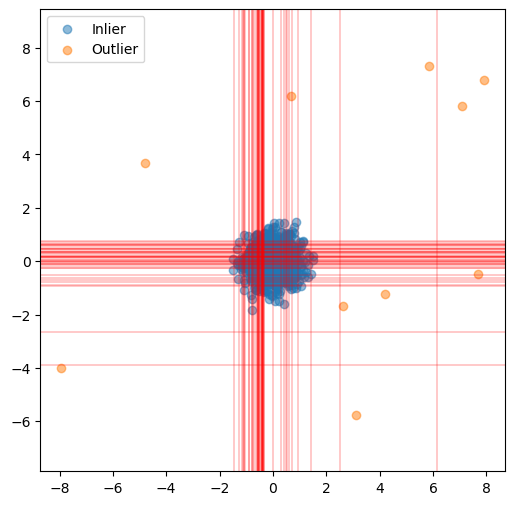

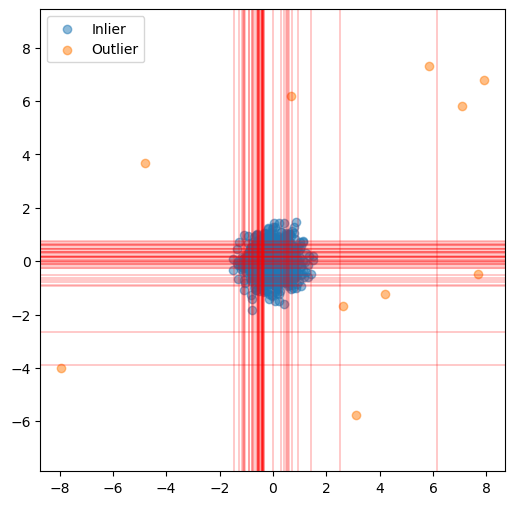

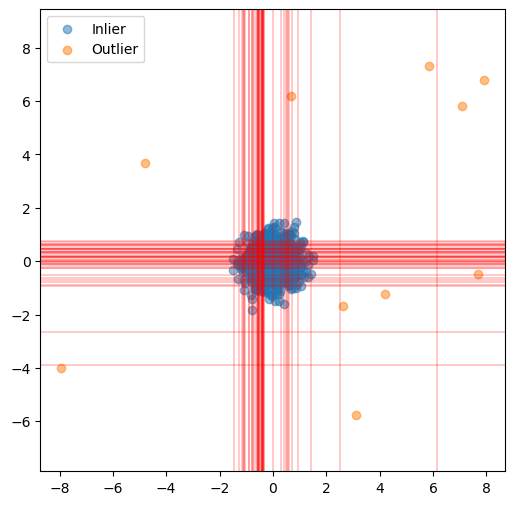

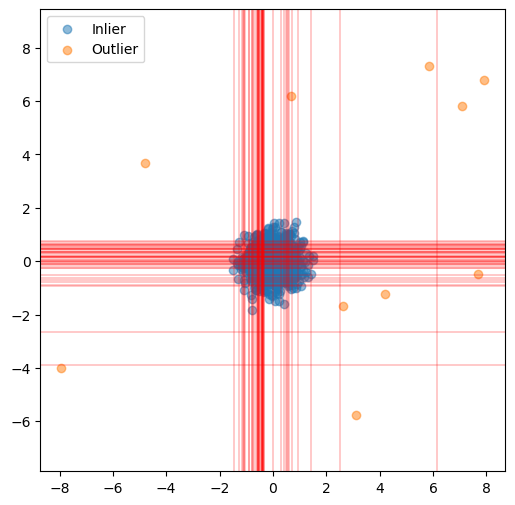

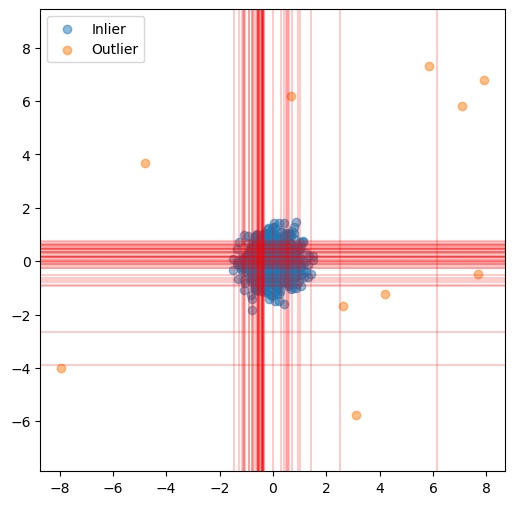

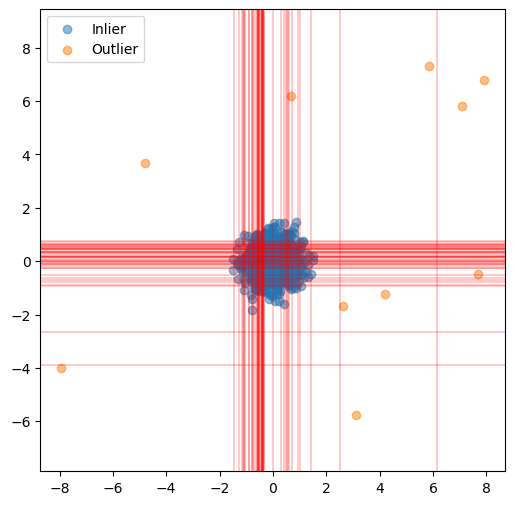

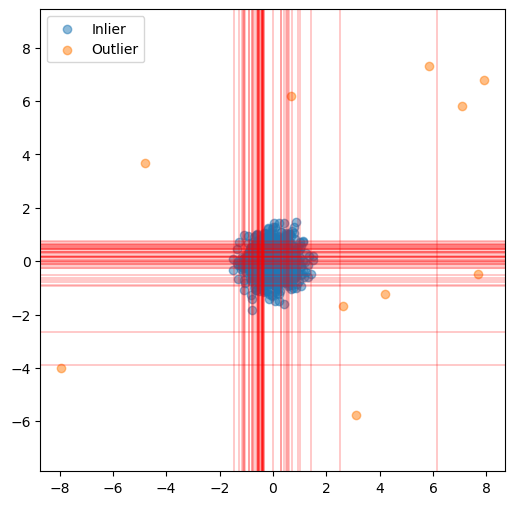

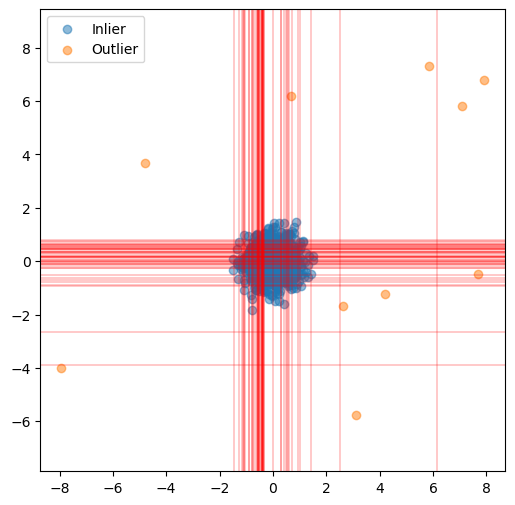

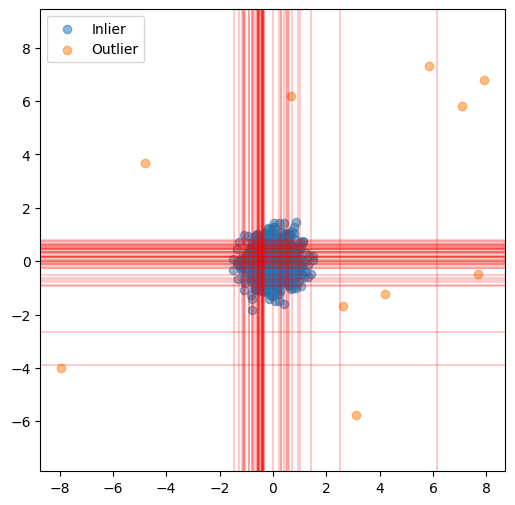

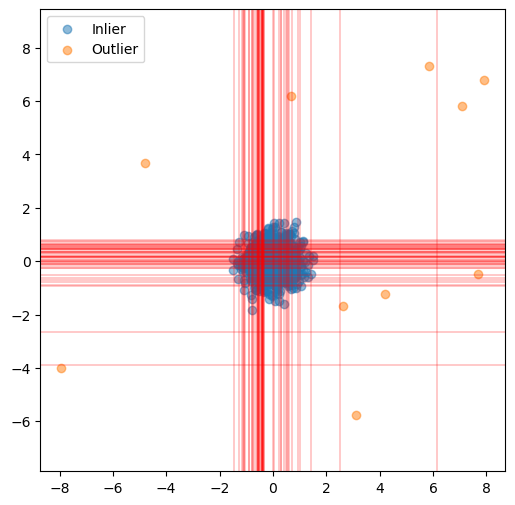

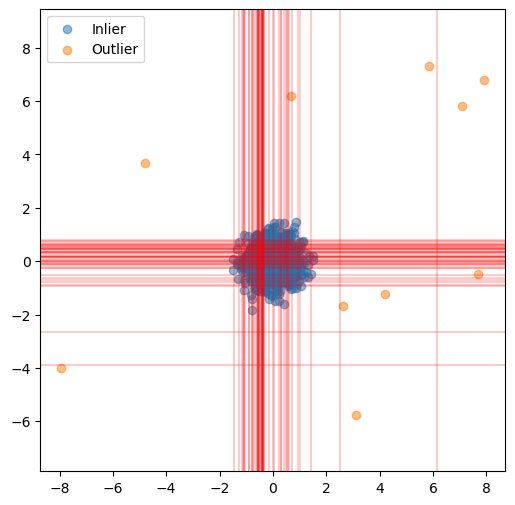

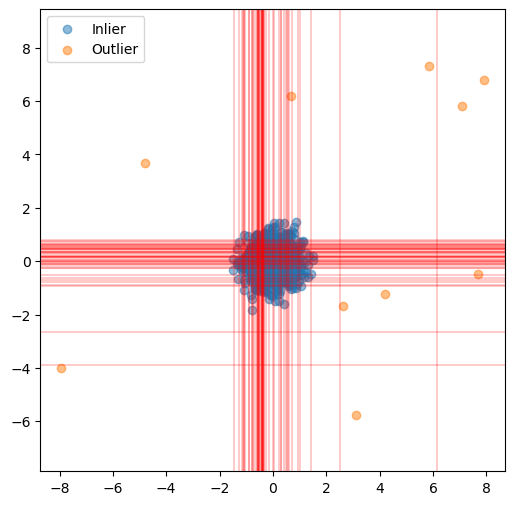

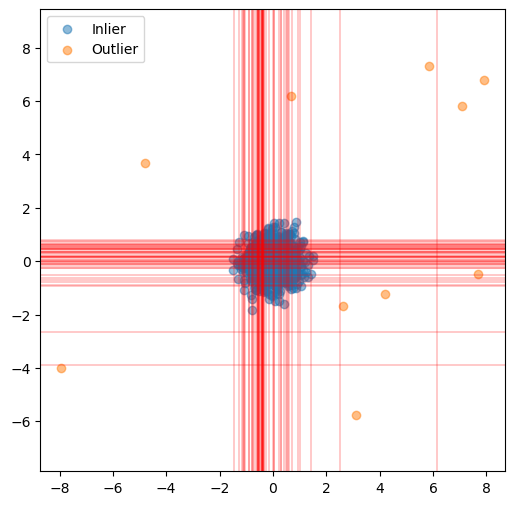

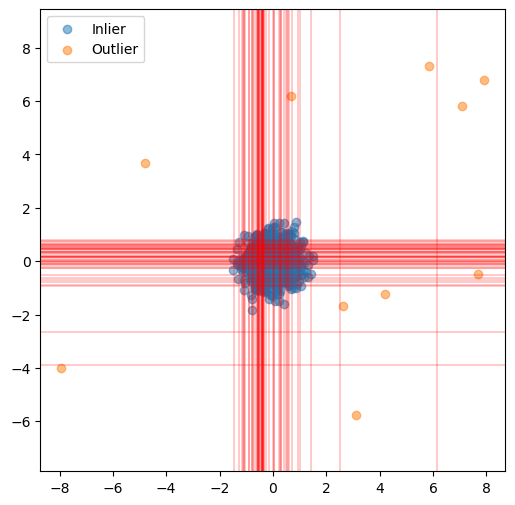

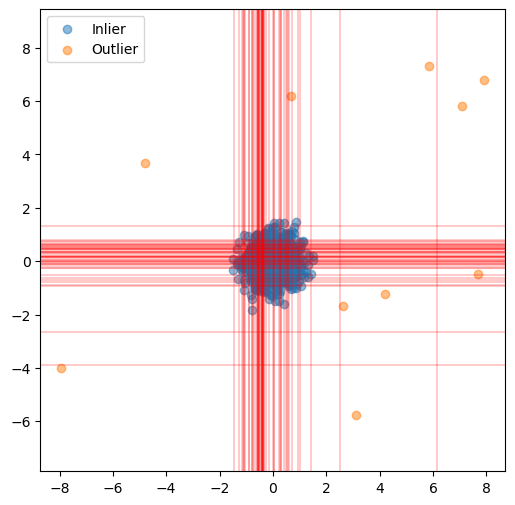

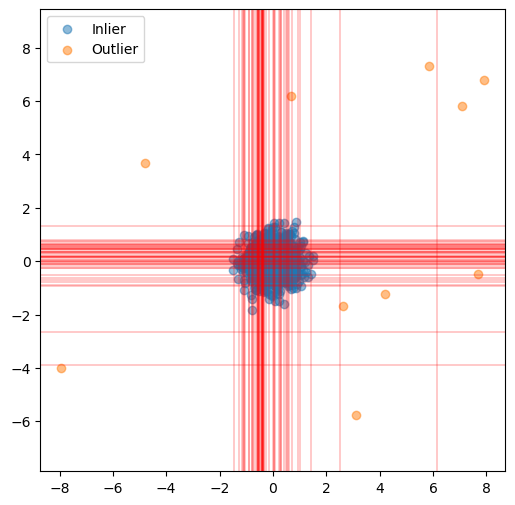

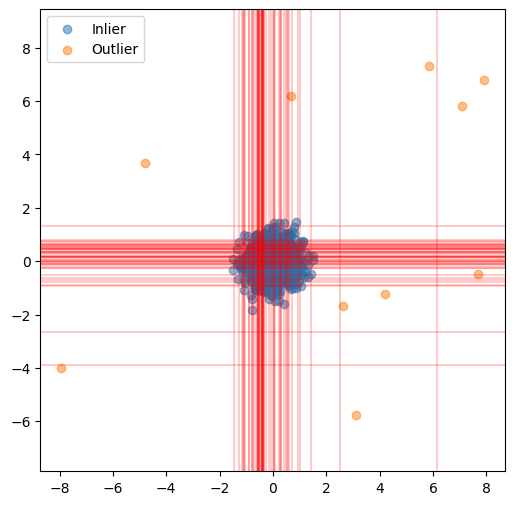

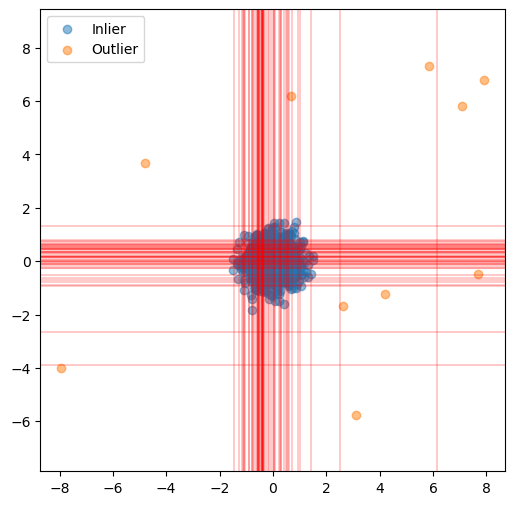

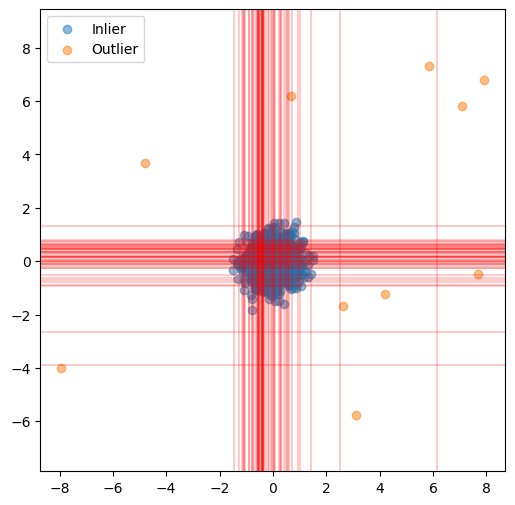

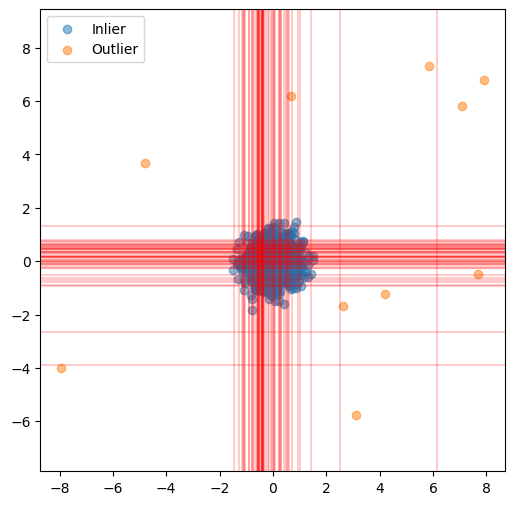

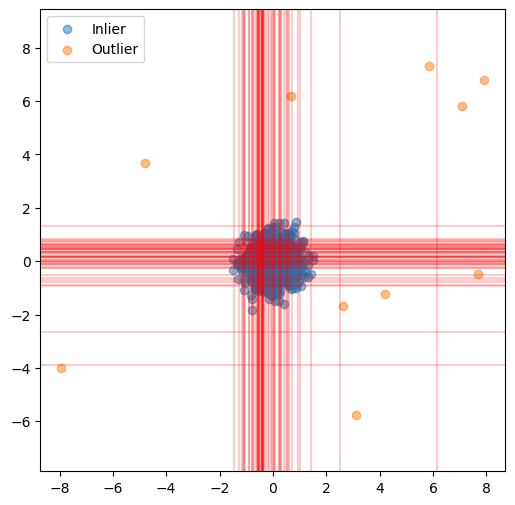

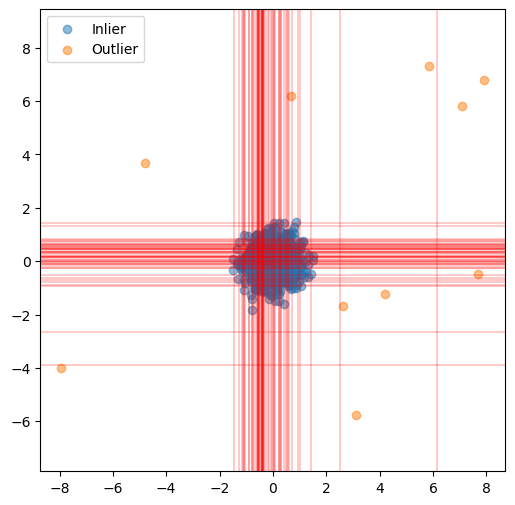

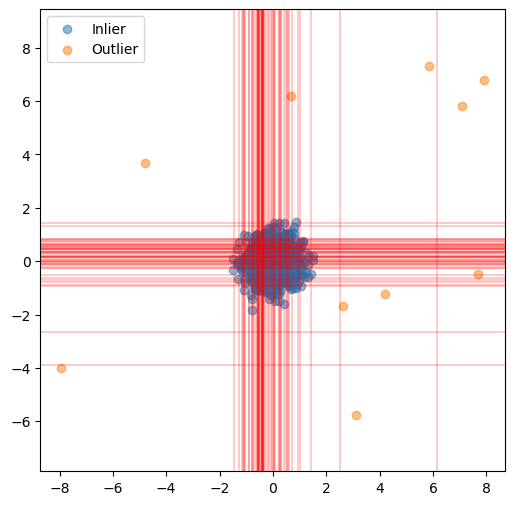

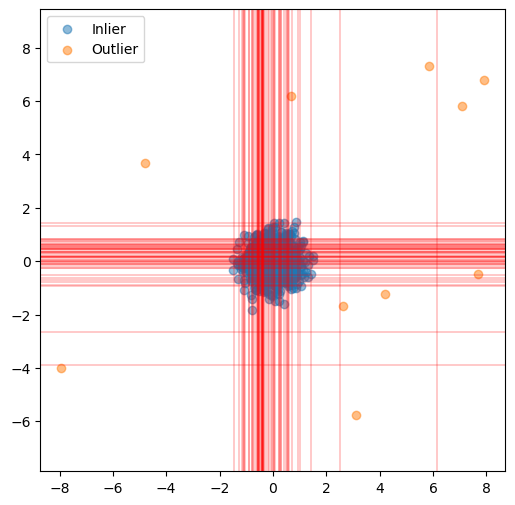

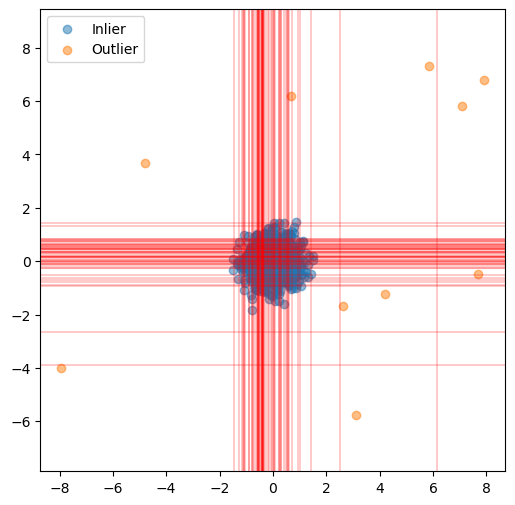

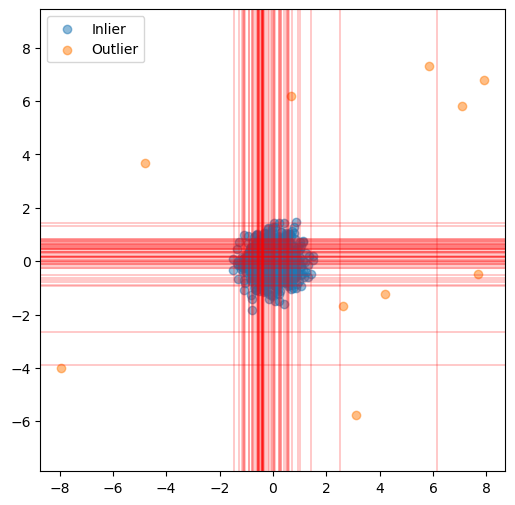

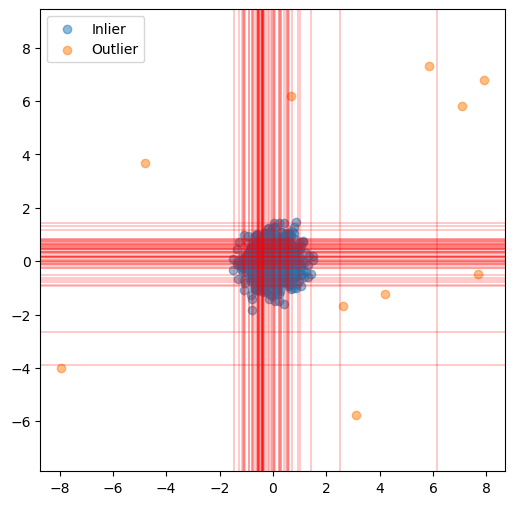

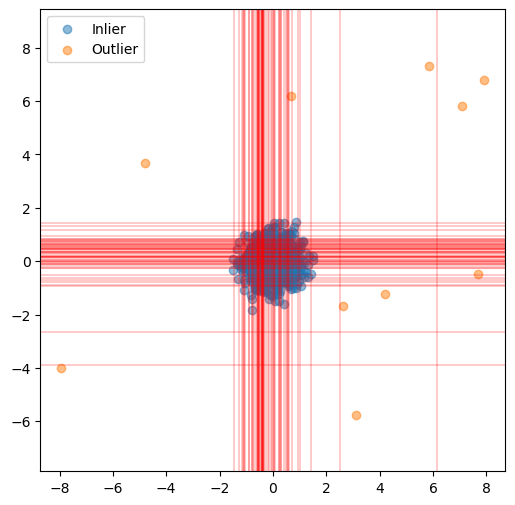

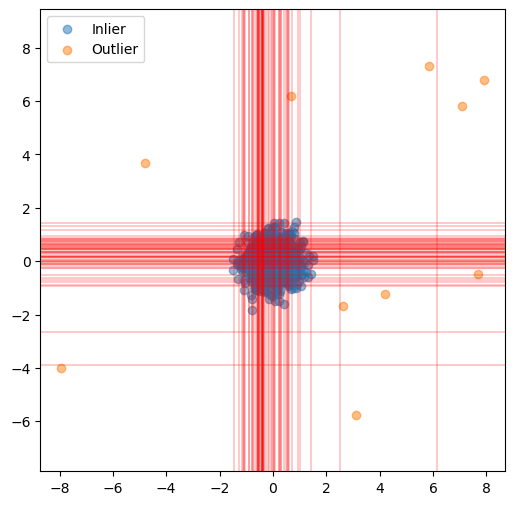

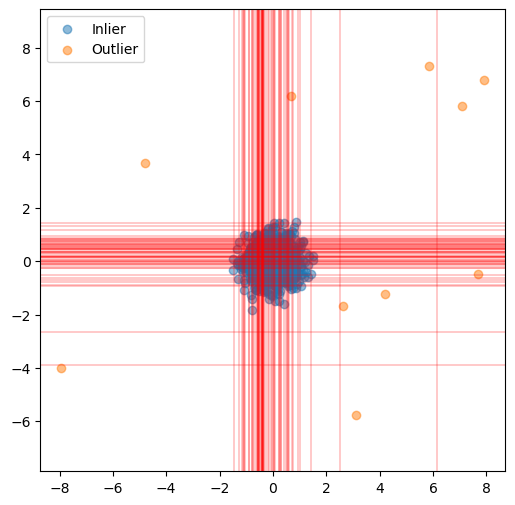

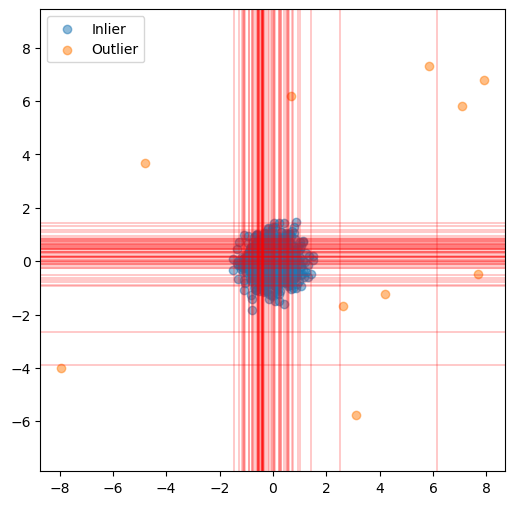

In [109]:
est = 1

for i in np.arange(clf.estimators_[est].tree_.feature.shape[0]):
    if clf.estimators_[est].tree_.feature[i] in clf.estimators_features_[0]:    
        plt.figure(figsize= (6, 6))
        plt.scatter(x = X_train.x1, y = X_train.x2, alpha = 0.5, label= 'Inlier')
        plt.scatter(x = X_outliers.x1, y = X_outliers.x2, alpha= 0.5, label= 'Outlier')        
        for j in np.arange(i):    
            if clf.estimators_[est].tree_.feature[j] == 0:
                plt.axvline(x= clf.estimators_[est].tree_.threshold[j], color= 'red', lw= 0.3)
            elif clf.estimators_[est].tree_.feature[j] == 1:
                plt.axhline(y= clf.estimators_[est].tree_.threshold[j], color= 'red', lw= 0.3)
        plt.legend()
        plt.axis('equal')
        plt.show()   